202311_jedha_bloc3_ChallengeML
Beraud Mélanie

www.datascienceweekly.org is a famous newsletter curated by independent data scientists. Anyone can register his/her e-mail address on this website to receive weekly news about data science and its applications !


# Import libraries

In [1]:
import pandas as pd
import numpy as np

# Preprocessing
import math
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline

# Model - base estimators
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Model - Ensemble methods
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier

# Model - Scoring
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.tree import plot_tree


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


from plotly.subplots import make_subplots
# Ma palette pour les plotly
pio.templates["mel_purple"] = go.layout.Template(
    layout_colorway=['#FF34B3', '#CD2990', '#8B1C62', '#CD00CD', '#8B008B', '#8968CD', '#5D478B','#20B2AA']) #'#EEA2AD', trop proche

pio.templates.default = "mel_purple"
pio.renderers.default = 'notebook_connected' # to be replaced by "iframe_connected" to have the pictures in files

from IPython.display import display

# Functions

In [14]:
# Preprocessing function:
def prepare_datasets(donnees, name_dataset, percent):

    ''' 
    Should be given:
    * data to process
    * name for the dataset in ''
    The function will prepare Features X/Target Y datatsets, train/val subsets: Splitting and Preprocessing
    And return (in that order):
        * 4 preprocessed datasets (X_train, X_val, y_train, y_val) 
        * list of names for num features, cat features from input dataset
        * name of X_train/X_val columns
        * the name of the dataset for log
    '''
    name_dataset = name_dataset

    X = donnees.drop('converted', axis = 1)
    Y = donnees.loc[:, 'converted']
    print(type(X), X.shape, type(Y), Y.shape)

    # Train_val split
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=percent, random_state=0, stratify = Y)
    #X_train[0:5], y_val[0:5]

    # Recovery features category_name
    num_features = []
    cat_features = []

    for col in X_train:
        if X_train[col].dtypes == 'int64' or X_train[col].dtypes == 'float64':
            num_features.append(col)
        else:
            cat_features.append(col)

    num_features = num_features
    print(f'num_features are:{num_features},\ncat_features are:{cat_features}')

    # Preprocessings
    norm = StandardScaler()
    encod = OneHotEncoder(drop="first")

    preprocesseur = ColumnTransformer(transformers=[
    ('num', norm, num_features),
    ('cat', encod, cat_features)])
    
    X_train = preprocesseur.fit_transform(X_train)
    X_val = preprocesseur.transform(X_val)

    # recovery of columns names in X_train and X_val
    liste_features_name = []    
    for name in preprocesseur.get_feature_names_out():
        liste_features_name.append(name[5:])
    #print(liste_features_name, liste_features_name[0], liste_features_name[1])

    print (f'Dataset {name_dataset} is ready.')

    return X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset, percent # useless, preprocesseur
    #X_train[0:5], y_train[0:5], X_val[0:5], y_val[0:5], y_train.value_counts(), y_val.value_counts()

# PROBLEM.... I do not return my encod and norm... -> I cannot do an inverse transform to check data ...
# X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset = prepare_datasets(data, 'full')

def model_scores(name_model, model, name_dataset, pourcentage_val, liste_features_name):
    
    ''' 
    Should be given:
    * name you want to give your model as name_model in ''
    * name of the model as a variable_should be gridsearch_Best_estimators_ if gridsearch
    * name of the dataset. You can use name_dataset from the preprocessing

    The function will return in a dataframe:
    * the accuracy for train and val, 
    * the prediction, 
    * the f1 score for train and val,
    * the full parameters of the classifier
    * the coefficients, 
    * the confusion matix, 
    * the classification report 
    and put everything in a dataframe that can be called.

    It will also display a few intersting tables...
    '''
    pourcentage_val = pourcentage_val
    name_model = name_model
    name_dataset = name_dataset
    model = model
    liste_features_name = liste_features_name # ajouté 20231205_non testé


    # Predictions

    y_train_pred = model.predict(X_train)  # irrécupérables car enreistrés en tant que str :( :( :(
    y_val_pred = model.predict(X_val)

    #scores
    accuracy_train = model.score(X_train, y_train)
    accuracy_val = model.score(X_val, y_val)

    f1_train = f1_score(y_train, y_train_pred)
    f1_val = f1_score(y_val, y_val_pred)


    parametres = model.get_params()
    parametres['percent_val'] =  pourcentage_val
    

    try:
        coefficients = [coef for coef in model.coef_]
    except:
        coefficients =[]
        
    report_train = classification_report(y_train, y_train_pred)
    report_val = classification_report(y_val, y_val_pred)

    print('classification report train')
    print(report_train)
    print('classification report val')
    print(report_val)

    # Confusion matrix
    tn_val, fp_val = confusion_matrix(y_val, y_val_pred)[0,0], confusion_matrix(y_val, y_val_pred)[0,1]
    fn_val, tp_val = confusion_matrix(y_val, y_val_pred)[1,0], confusion_matrix(y_val, y_val_pred)[1,1]

    tn_train, fp_train = confusion_matrix(y_train, y_train_pred)[0,0], confusion_matrix(y_train, y_train_pred)[0,1]
    fn_train, tp_train = confusion_matrix(y_train, y_train_pred)[1,0], confusion_matrix(y_train, y_train_pred)[1,1]
    
    #tn_val, fp_val, fn_val, tp_val

    #Confusion matrix    
    print('matrices de confusion')
    fig_train , ax1 = plt.subplots()
    ax1.set(title="Confusion Matrix on Train set") 
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, ax=ax1) 
    fig_train.show('notebook_connected')

    fig_val , ax2 = plt.subplots()
    ax2.set(title="Confusion Matrix on val set") 
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, ax=ax2) 
    fig_val.show() 



    report = [name_model, model, name_dataset,  parametres, 
              accuracy_train, accuracy_val, coefficients, 
              y_train_pred, y_val_pred, f1_train, f1_val, 
              tn_val, fp_val, fn_val, tp_val,
              tn_train, fp_train, fn_train, tp_train,
              report_train, report_val, liste_features_name]

    

    dataf  = pd.DataFrame(data=[], columns = ['name_model', 'model', 'name_dataset',  'parametres', 
              'accuracy_train', 'accuracy_val', 'coefficients', 
              'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 
              'tn_val', 'fp_val', 'fn_val', 'tp_val',
              'tn_train', 'fp_train', 'fn_train', 'tp_train',
              'report_train', 'report_val', 'features_name'])
    

      
    
    dataf.loc[len(dataf), :] = report

    '''
    # model.get_params().__getitem__('C')

    coeff= pd.DataFrame(test['coefficients'][0])
    coeff
    '''
    # presentation
    liste_scores = ['name_model', 'model', 'name_dataset', 'accuracy_train', 'accuracy_val', 'f1_train', 'f1_val']
    liste_confusionMatrix = ['name_model', 'model', 'name_dataset', 'tn_val', 'fp_val', 'fn_val', 'tp_val',
              'tn_train', 'fp_train', 'fn_train', 'tp_train']
    liste_params = ['name_model', 'model', 'name_dataset',  'parametres', 'coefficients']

 
    scores = dataf.loc[:, liste_scores]
    confusion = dataf.loc[:, liste_confusionMatrix]
    parametre = dataf.loc[:, liste_params]
    # adapter les parametre selon le type de modèle... et les coeff selon le nb de coeff


    display(scores, confusion, parametre)
    print(f'This function returns a Reporting DataFrame composed of:\n   {[col for col in dataf.columns]}')

    
    return dataf
#resultats_df = model_scores('name_model', model, name_dataset)

def nom_variable(str):
    return str

def feature_eng(x):
    #fonction pour faire du feature_engineering... Retourne 7 valeurs par variables numérique.
    return x**2, np.sqrt(x), 1/x, math.exp(x), math.log10(x), math.log1p(x), math.cos(x)
#len(feature_eng(2))


# Import data

In [15]:
# no need to run for EDA
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)


# Preprocessng des new_user as category
data.new_user = data.new_user.astype('category')
data.info()

# super clean : 4 categories for country + 3 categories for source
# Target = converted 0/1 -classification

final_scoring = pd.read_csv('final_scoring.csv')
final_scoring

Set with labels (our train+test) : (284580, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   country              284580 non-null  object  
 1   age                  284580 non-null  int64   
 2   new_user             284580 non-null  category
 3   source               284580 non-null  object  
 4   total_pages_visited  284580 non-null  int64   
 5   converted            284580 non-null  int64   
dtypes: category(1), int64(3), object(2)
memory usage: 11.1+ MB


,name_model,model,name_dataset,parametres,accuracy_train,accuracy_val,coefficients,y_train_pred,y_val_pred,f1_train,...,fp_val,fn_val,tp_val,tn_train,fp_train,fn_train,tp_train,report_train,report_val,features_name
0,reglog_full,LogisticRegression(),full,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.986331,0.985769,"[array([-0.59420066, 2.54863047, 3.57655197,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.765451,...,225,585,1251,219474,846,2266,5078,precision recall f1-score ...,precision recall f1-score ...,NaN
1,reglog_gs,LogisticRegression(C=0.1),full,"{'C': 0.1, 'class_weight': None, 'dual': False...",0.986318,0.985628,"[array([-0.5864657 , 2.51598049, 2.66063539,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.764390,...,225,593,1243,219496,824,2291,5053,precision recall f1-score ...,precision recall f1-score ...,NaN
2,reglog_ada_gs,AdaBoostClassifier(estimator=LogisticRegressio...,full,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.985110,0.984310,[],[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.735693,...,214,679,1157,219556,764,2626,4718,precision recall f1-score ...,precision recall f1-score ...,NaN
3,bag_tree_gs,BaggingClassifier(estimator=DecisionTreeClassi...,full,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.984543,0.984205,[],[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.729245,...,234,665,1171,219406,914,2605,4739,precision recall f1-score ...,precision recall f1-score ...,NaN
4,bag_tree_gs,BaggingClassifier(estimator=DecisionTreeClassi...,full,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.985373,0.984503,[],[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.750412,...,274,608,1228,219328,992,2338,5006,precision recall f1-score ...,precision recall f1-score ...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,reglog_new_user,LogisticRegression(C=1),1col,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.986376,0.985921,"[array([-0.5936974 , 2.53619193, 3.54553348,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.766115,...,338,864,1890,192047,733,1981,4445,precision recall f1-score ...,precision recall f1-score ...,NaN
63,reglog_source,LogisticRegression(C=1),1col,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.986376,0.985921,"[array([-0.5936974 , 2.53619193, 3.54553348,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.766115,...,338,864,1890,192047,733,1981,4445,precision recall f1-score ...,precision recall f1-score ...,NaN
64,reglog_total_pages_visited,LogisticRegression(C=1),1col,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.986376,0.985921,"[array([-0.5936974 , 2.53619193, 3.54553348,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.766115,...,338,864,1890,192047,733,1981,4445,precision recall f1-score ...,precision recall f1-score ...,NaN
65,reglog_converted,LogisticRegression(C=1),1col,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.986376,0.985921,"[array([-0.5936974 , 2.53619193, 3.54553348,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.766115,...,338,864,1890,192047,733,1981,4445,precision recall f1-score ...,precision recall f1-score ...,NaN


In [25]:
#Sauvegarde final_scoring

final_scoring.to_csv('final_scoring.csv', index=False) 

### Garder en tête : Il y a des ousiders en age : 110 et 120 ans. Record reconnu de tous les ltemps : Jeanne Calmant 121 ans.

### Preprocessing before separation :
No NaN, encoding cat = ok
### Preprocessing after separation:
OneHotEncoder for 3 cat, norm for 2 num

In [ ]:
train_sample = pd.DataFrame(X_train[:,:2], columns = [liste_features_name[0], liste_features_name[1]]).sample(10000)
val_sample = pd.DataFrame(X_val[:,:2], columns = [liste_features_name[0], liste_features_name[1]]).sample(10000)
#val_sample.head()

print(train_sample.shape, val_sample.shape)


fig = make_subplots(rows = 1, cols = 4)#, figsize=[10,20])

fig.add_trace(px.histogram(train_sample[liste_features_name[0]]).data[0], row = 1, col=1)
fig.add_trace(px.histogram(train_sample[liste_features_name[1]]).data[0], row = 1, col=2)
fig.add_trace(px.histogram(val_sample[liste_features_name[0]]).data[0], row = 1, col=3)
fig.add_trace(px.histogram(val_sample[liste_features_name[1]]).data[0], row = 1, col=4)
fig.update_layout(showlegend=False, width=1200, height =400)


display(fig)


Prendre les attributs 1 à 1 ne hange rien

## Training pipeline

### Most important features 
seems to be The number of pages visited (positive correlation) and the country, the new user variable
Impact of sources is not that important, age neither.

### scores
F1 and accracy scores are basically the same for train and test

### Confusion matrice:
30% errors ont the positives labels (30% have been predicted as negative)
15% predicted neg should be true.

We need to work on the 30% errors...
Try with a gradient ?



# Data - Feature engineering

### Datasets - Splitting, Preprocessing

In [16]:
# all columns = 'full'
data
name_dataset = 'full'

# nombre de features---------------------------------------------

# 3feat: feature - engineering sans colonnes: 
#data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'converted']]
#name_dataset = '3feat'

# 3fage: 
#data = data.loc[:, ['total_pages_visited', 'new_user', 'country', 'converted']]
#name_dataset = '3fage'


##4f - not eng.
#data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'country', 'converted']]
#name_dataset = '4f'

# Sampling -------------------------------------------------

##sample 1000
#data = data.sample(1000)
#name_dataset = '1000'

##sample 10000
'''
#data = data.sample(10000)#, axis='converted')
#print(data.shape)
#name_dataset = '10000'

data['converted'].value_counts()
converted
0    9688
1     312
Name: count, dtype: int64
'''

#feat_eng ------------------------------------
'''
# Feature_eng data['age'] 
data['age_carre'], data['age_sq'], data['age_demi'], \
    data['age_exp'], data['age_log10'], data['age_ln'],\
          data['age_cos'] = data['age'].apply(lambda x: feature_eng(x)[0]), data['age'].apply(lambda x: feature_eng(x)[1]), data['age'].apply(lambda x: feature_eng(x)[2]), \
            data['age'].apply(lambda x: feature_eng(x)[3]), data['age'].apply(lambda x: feature_eng(x)[4]), data['age'].apply(lambda x: feature_eng(x)[5]), \
            data['age'].apply(lambda x: feature_eng(x)[6])

# Feature_eng data['total_pages_visited'] 
data['total_pages_visited_carre'], data['total_pages_visited_sq'], data['total_pages_visited_demi'], \
    data['total_pages_visited_exp'], data['total_pages_visited_log10'], data['total_pages_visited_ln'],\
          data['total_pages_visited_cos'] = data['total_pages_visited'].apply(lambda x: feature_eng(x)[0]), data['total_pages_visited'].apply(lambda x: feature_eng(x)[1]), data['total_pages_visited'].apply(lambda x: feature_eng(x)[2]), \
            data['total_pages_visited'].apply(lambda x: feature_eng(x)[3]), data['total_pages_visited'].apply(lambda x: feature_eng(x)[4]), data['total_pages_visited'].apply(lambda x: feature_eng(x)[5]), \
            data['total_pages_visited'].apply(lambda x: feature_eng(x)[6])

## Trouver un moyen de le faire compréhensif... Pas réussi comme ça, mais ça doit se faire.

'''
##4feat_data_eng
#data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'country', 'converted']]
#data['age_demi'], data['total_pages_visited_carre'] = data['age'].apply(lambda x: feature_eng(x)[2]), data['total_pages_visited'].apply(lambda x: feature_eng(x)[0])
#data = data.drop(['total_pages_visited', 'age'], axis = 1)
#name_dataset = '4f_eng'

##4f_eng2
#data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'country', 'converted']]
#data['age_quart'], data['total_pages_visited_demi'] = data['age'].apply(lambda x: x/4), data['total_pages_visited'].apply(lambda y: y/2)
#data = data.drop(['total_pages_visited', 'age'], axis = 1)
#name_dataset = '4f_eng2'

##4f_eng3
#data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'country', 'converted']]
#data['age_quart'], data['total_pages_visited_demi'] = data['age'].apply(lambda x: x/4), data['total_pages_visited'].apply(lambda x: x/2)
#data = data.drop(['total_pages_visited', 'age'], axis = 1)
#name_dataset = '4f_eng3'

##4f_eng4
data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'country', 'converted']]
data['age_quart'], data['total_pages_visited_demi'] = data['age'].apply(lambda x: x**2), data['total_pages_visited'].apply(lambda x: x**4)
data = data.drop(['total_pages_visited', 'age'], axis = 1)
name_dataset = '4f_eng4'

'''
##data_sup/data_inf ---------------------

### Keep the indexes to be able to sort afterwards and recover the data in the right order if required for evaluation or for prediction (needs to be well made)
index_sup = [item for item in data.loc[data['total_pages_visited'] > 13, : ].index] # équivaut à > 13 pages visitées 
index_inf = [item for item in data.loc[data['total_pages_visited'] <= 13, : ].index] 

print(len(index_sup), len(index_inf),  len(data), len(index_inf) + len(index_sup))
# to keep for later


### create 2 datasets according to the norm_total_pages_visited
data_sup = data.loc[data['total_pages_visited'] > 13, : ]
data_sup.reset_index(inplace=True)
data_sup = data_sup.drop('index', axis = 1)

data_inf = data.loc[data['total_pages_visited'] <= 13, : ]
data_inf.reset_index(inplace=True)
data_inf = data_inf.drop('index', axis = 1)

data_sup.shape, data_inf.shape, data_sup.head()


# il faudra réindexer plus tard....
### pour réindexer plus tard, il faudra recréer un dataframe, ajouter la colonne index avec les valeurs que je connais, fusionner sup et inf et trier.... 
#temp_sup_test = temp_sup.reset_index(names=index_test) # ne fonctionne pas
#temp_sup_test.index = temp_sup_test['index']

# data_inf
data = data_inf

# data_sup
#data = data_sup

data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'country', 'converted']]
data['age_quart'], data['total_pages_visited_demi'] = data['age'].apply(lambda x: x/4), data['total_pages_visited'].apply(lambda x: x/2)
data = data.drop(['total_pages_visited', 'age'], axis = 1)
#name_dataset = '4f_sup'

'''
data.head()

X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset, percent = prepare_datasets(data, name_dataset, 0.3) 

#X_train[0:5], type(X_train), len(X_train), y_train[0:5], type(y_train), len(y_train), X_train [0], y_train[0] # attention aux index
len(X_train) + len(X_val)

<class 'pandas.core.frame.DataFrame'> (284580, 4) <class 'pandas.core.series.Series'> (284580,)
num_features are:['age_quart', 'total_pages_visited_demi'],
cat_features are:['new_user', 'country']
Dataset 4f_eng4 is ready.


284580

In [7]:
## Not needed anymore _ 4f_sup/4f_inf

### recreate Dataframe with X and y
temp_t = pd.DataFrame(X_train, columns=liste_features_name)
temp_t = temp_t.reset_index()
temp_t = temp_t.drop('index', axis =1)

temp_t['y'] = y_train.values # je dois rindexer et prendre les valeurs, sinon il prend les valeurs de y et ça déconne
temp_t.head()

### Keep the indexes to be able to sort afterwards and recover the data in the right order if required for evaluation or for prediction (needs to be well made)
index_inf = [item for item in temp_t.loc[temp_t['total_pages_visited'] <= 2.281, : ].index] 
index_sup = [item for item in temp_t.loc[temp_t['total_pages_visited'] > 2.281, : ].index] # équivaut à > 13 pages visitées 

len(index_inf), len(index_sup), len(index_inf) + len(index_sup)
# to keep for later


### create 2 datasets according to the norm_total_pages_visited
temp_t_sup = temp_t.loc[temp_t['total_pages_visited'] > 2.281, : ]
temp_t_sup.reset_index(inplace=True)
temp_t_sup = temp_t_sup.drop('index', axis = 1)

temp_t_inf = temp_t.loc[temp_t['total_pages_visited'] <= 2.281, : ]
temp_t_inf.reset_index(inplace=True)
temp_t_inf = temp_t_inf.drop('index', axis = 1)

temp_t_sup.shape, temp_t_inf.shape, temp_t_sup.head()

# il faudra réindexer plus tard....

### recreate set X_train, X_test sets....

X_sup_t = temp_t_sup.drop('y', axis = 1)
y_sup_t = temp_t_sup.loc[:,'y']

X_inf_t = temp_t_inf.drop('y', axis = 1)
y_inf_t = temp_t_inf.loc[:,'y']

print(X_sup_t.shape, len(y_sup_t), X_inf_t.shape, len(y_inf_t))
X_sup_t.head() #ok


### pour réindexer plus tard, il faudra recréer un dataframe, ajouter la colonne index avec les valeurs que je connais, fusionner sup et inf et trier.... 
#temp_sup_test = temp_sup.reset_index(names=index_test) # ne fonctionne pas
#temp_sup_test.index = temp_sup_test['index']

# Si nécessaire, car peut être que je n'aurais pas besoin daller faire pareil dans le test set...

# ca donne des résultats bizarres car je ne renormalse pas après la séparation.... Donc faire pareil sur data_eng4

X_train, y_train = X_inf_t, y_inf_t
X_train.shape, len(y_train)



### recreate Dataframe with X and y
temp_v = pd.DataFrame(X_val, columns=liste_features_name)
temp_v = temp_v.reset_index()
temp_v = temp_v.drop('index', axis =1)

temp_v['y'] = y_val.values # je dois rindexer et prendre les valeurs, sinon il prend les valeurs de y et ça déconne
temp_v.head()

### Keep the indexes to be able to sort afterwards and recover the data in the right order if required for evaluation or for prediction (needs to be well made)
index_inf = [item for item in temp_v.loc[temp_v['total_pages_visited'] <= 2.281, : ].index] 
index_sup = [item for item in temp_v.loc[temp_v['total_pages_visited'] > 2.281, : ].index] # équivaut à > 13 pages visitées 

len(index_inf), len(index_sup), len(index_inf) + len(index_sup)
# to keep for later


### create 2 datasets according to the norm_total_pages_visited
temp_v_sup = temp_v.loc[temp_v['total_pages_visited'] > 2.281, : ]
temp_v_sup.reset_index(inplace=True)
temp_v_sup = temp_v_sup.drop('index', axis = 1)

temp_v_inf = temp_v.loc[temp_v['total_pages_visited'] <= 2.281, : ]
temp_v_inf.reset_index(inplace=True)
temp_v_inf = temp_v_inf.drop('index', axis = 1)

temp_v_sup.shape, temp_v_inf.shape, temp_v_sup.head()

# il faudra réindexer plus tard....

### recreate set X_train, X_test sets....

X_sup_v = temp_v_sup.drop('y', axis = 1)
y_sup_v = temp_v_sup.loc[:,'y']

X_inf_v = temp_v_inf.drop('y', axis = 1)
y_inf_v = temp_v_inf.loc[:,'y']

print(X_sup_v.shape, len(y_sup_v), X_inf_v.shape, len(y_inf_v))
X_sup_v.head() #ok


(7158, 6) 7158 (220506, 6) 220506


,age,total_pages_visited,new_user_1,country_Germany,country_UK,country_US
0,-0.794779,3.328593,1.0,1.0,0.0,0.0
1,-0.915643,3.627790,1.0,0.0,0.0,1.0
2,-1.278235,4.226183,0.0,0.0,1.0,0.0
3,-1.036507,3.926986,0.0,0.0,0.0,1.0
4,-0.553051,4.226183,1.0,0.0,0.0,1.0


# Feature importance

In [54]:
#3feat_eng
data_num = data.loc[:, num_features]
corr_matrix = data_num.corr().round(2)
corr_matrix # ça n'a pas changé le monde.

,age,total_pages_visited,age_carre,age_sq,age_demi,age_exp,age_log10,age_ln,age_cos,total_pages_visited_carre,total_pages_visited_sq,total_pages_visited_demi,total_pages_visited_exp,total_pages_visited_log10,total_pages_visited_ln,total_pages_visited_cos
age,1.00,-0.04,0.99,1.00,-0.95,0.05,0.99,0.99,-0.03,-0.06,-0.03,0.00,-0.01,-0.02,-0.02,-0.01
total_pages_visited,-0.04,1.00,-0.04,-0.04,0.04,-0.01,-0.04,-0.04,0.00,0.93,0.98,-0.72,0.15,0.91,0.94,0.12
age_carre,0.99,-0.04,1.00,0.97,-0.89,0.07,0.95,0.95,-0.02,-0.05,-0.03,0.00,-0.01,-0.02,-0.02,-0.01
age_sq,1.00,-0.04,0.97,1.00,-0.97,0.04,1.00,1.00,-0.04,-0.06,-0.03,0.00,-0.01,-0.02,-0.02,-0.01
age_demi,-0.95,0.04,-0.89,-0.97,1.00,-0.02,-0.99,-0.99,0.06,0.06,0.03,-0.00,0.01,0.02,0.02,0.01
age_exp,0.05,-0.01,0.07,0.04,-0.02,1.00,0.03,0.03,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01
age_log10,0.99,-0.04,0.95,1.00,-0.99,0.03,1.00,1.00,-0.05,-0.06,-0.03,0.00,-0.01,-0.02,-0.02,-0.01
age_ln,0.99,-0.04,0.95,1.00,-0.99,0.03,1.00,1.00,-0.05,-0.06,-0.03,0.00,-0.01,-0.02,-0.02,-0.01
age_cos,-0.03,0.00,-0.02,-0.04,0.06,-0.01,-0.05,-0.05,1.00,0.00,0.00,0.00,-0.02,0.00,0.00,0.00
total_pages_visited_carre,-0.06,0.93,-0.05,-0.06,0.06,-0.00,-0.06,-0.06,0.00,1.00,0.83,-0.47,0.27,0.70,0.75,0.09


In [90]:
temp = pd.DataFrame(X_train, columns=liste_features_name)
temp['y'] = y_train # si je passe par un concat, j'ai un soucis d'index
temp.head()


,age,total_pages_visited,new_user_1,country_Germany,country_UK,country_US,y
0,-1.399098,-1.159353,1.0,0.0,0.0,0.0,0.0
1,0.292995,0.037432,1.0,0.0,0.0,1.0,0.0
2,2.468545,-0.860157,1.0,0.0,0.0,1.0,1.0
3,-1.640826,-1.159353,0.0,0.0,0.0,0.0,0.0
4,-0.311324,0.037432,1.0,0.0,0.0,0.0,0.0


In [ ]:
# check features avec le plottree
# Perform grid search
decision_tree = DecisionTreeClassifier()

# importer le final scoring
# Grid of values to be tested
params = {
    'criterion':['gini','entropy','log_loss'],
    'max_depth': [4, 5, 8, 10],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4]
}

tree_simple_gs_m= GridSearchCV(decision_tree, param_grid = params, cv = 3)
tree_simple_gs_m .fit(X_train, y_train)

tree_simple_gs_4f_eng3  = model_scores('tree_simple_gs_4f_eng3 ', tree_simple_gs_m.best_estimator_, '4f_eng3 ', percent)

final_scoring= pd.concat([final_scoring,tree_simple_gs_4f_eng3])
#final_scoring.loc[final_scoring['name_model'] == 'tree_simple_gs', 'parametres'].values

# 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2,

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')

# peut être fait avec DBScan, mais ce serait triché en ML Supervised
# moins bon en 3 feat


# sur inf: 0.419415	0.404853... c'est toujours la détection de 1 qui pêche :(


In [ ]:
# Gridsearch gave these results : 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2,

# check features avec le plottree
#decision_tree_gini = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 1, min_samples_split = 2, criterion='gini')
#decision_tree_gini = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 1, min_samples_split = 2, criterion='gini') 
#0.7654 0.7343
#Gini Impurity: It also calculates the purity of the split at nodes of decision tree.
#Gini impurity varies between 0–0.5 .A node is pure when Gini attribute is 0 i.e., all instances are of same class.

#decision_tree_ent = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 1, min_samples_split = 2, criterion='entropy')
#0.7583 0.7375
#Entropy = 0 means it is pure split i.e., all instances are of only 1 class.
#Entropy=1 means Completely impure split i.e., equal instances (50%–50%) of both class at node causing extreme disorder.


decision_tree_log = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 1, min_samples_split = 2, criterion='log_loss')
#0.7583 0.7375


model = decision_tree_gini

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

print(round(f1_score(y_train, y_train_pred), 4), round(f1_score(y_val, y_val_pred), 4))

tree_log8_4f_eng3 = model_scores('tree_simple_log8', model, '4f_eng3')

final_scoring= pd.concat([final_scoring,tree_log8_4f_eng3])


# 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2,
# auss bien que le train sur la reg_log, mais moins bien sur le val. ca reste le meilleur arbre.

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')


'''
plt.figure(figsize=(400,50))
a = plot_tree(model, 
              feature_names=liste_features_name, 
              #class_names=class_names, 
              filled=True, 
              rounded=True, 
              fontsize=14)
plt.title(model)
'''
# pas assez avec 5 en max_depth
# keep criterion = gini, en fait, plutot entropy ou logloss sont les mieux...



Text(0.5, 1.0, 'DecisionTreeClassifier(max_depth=3)')

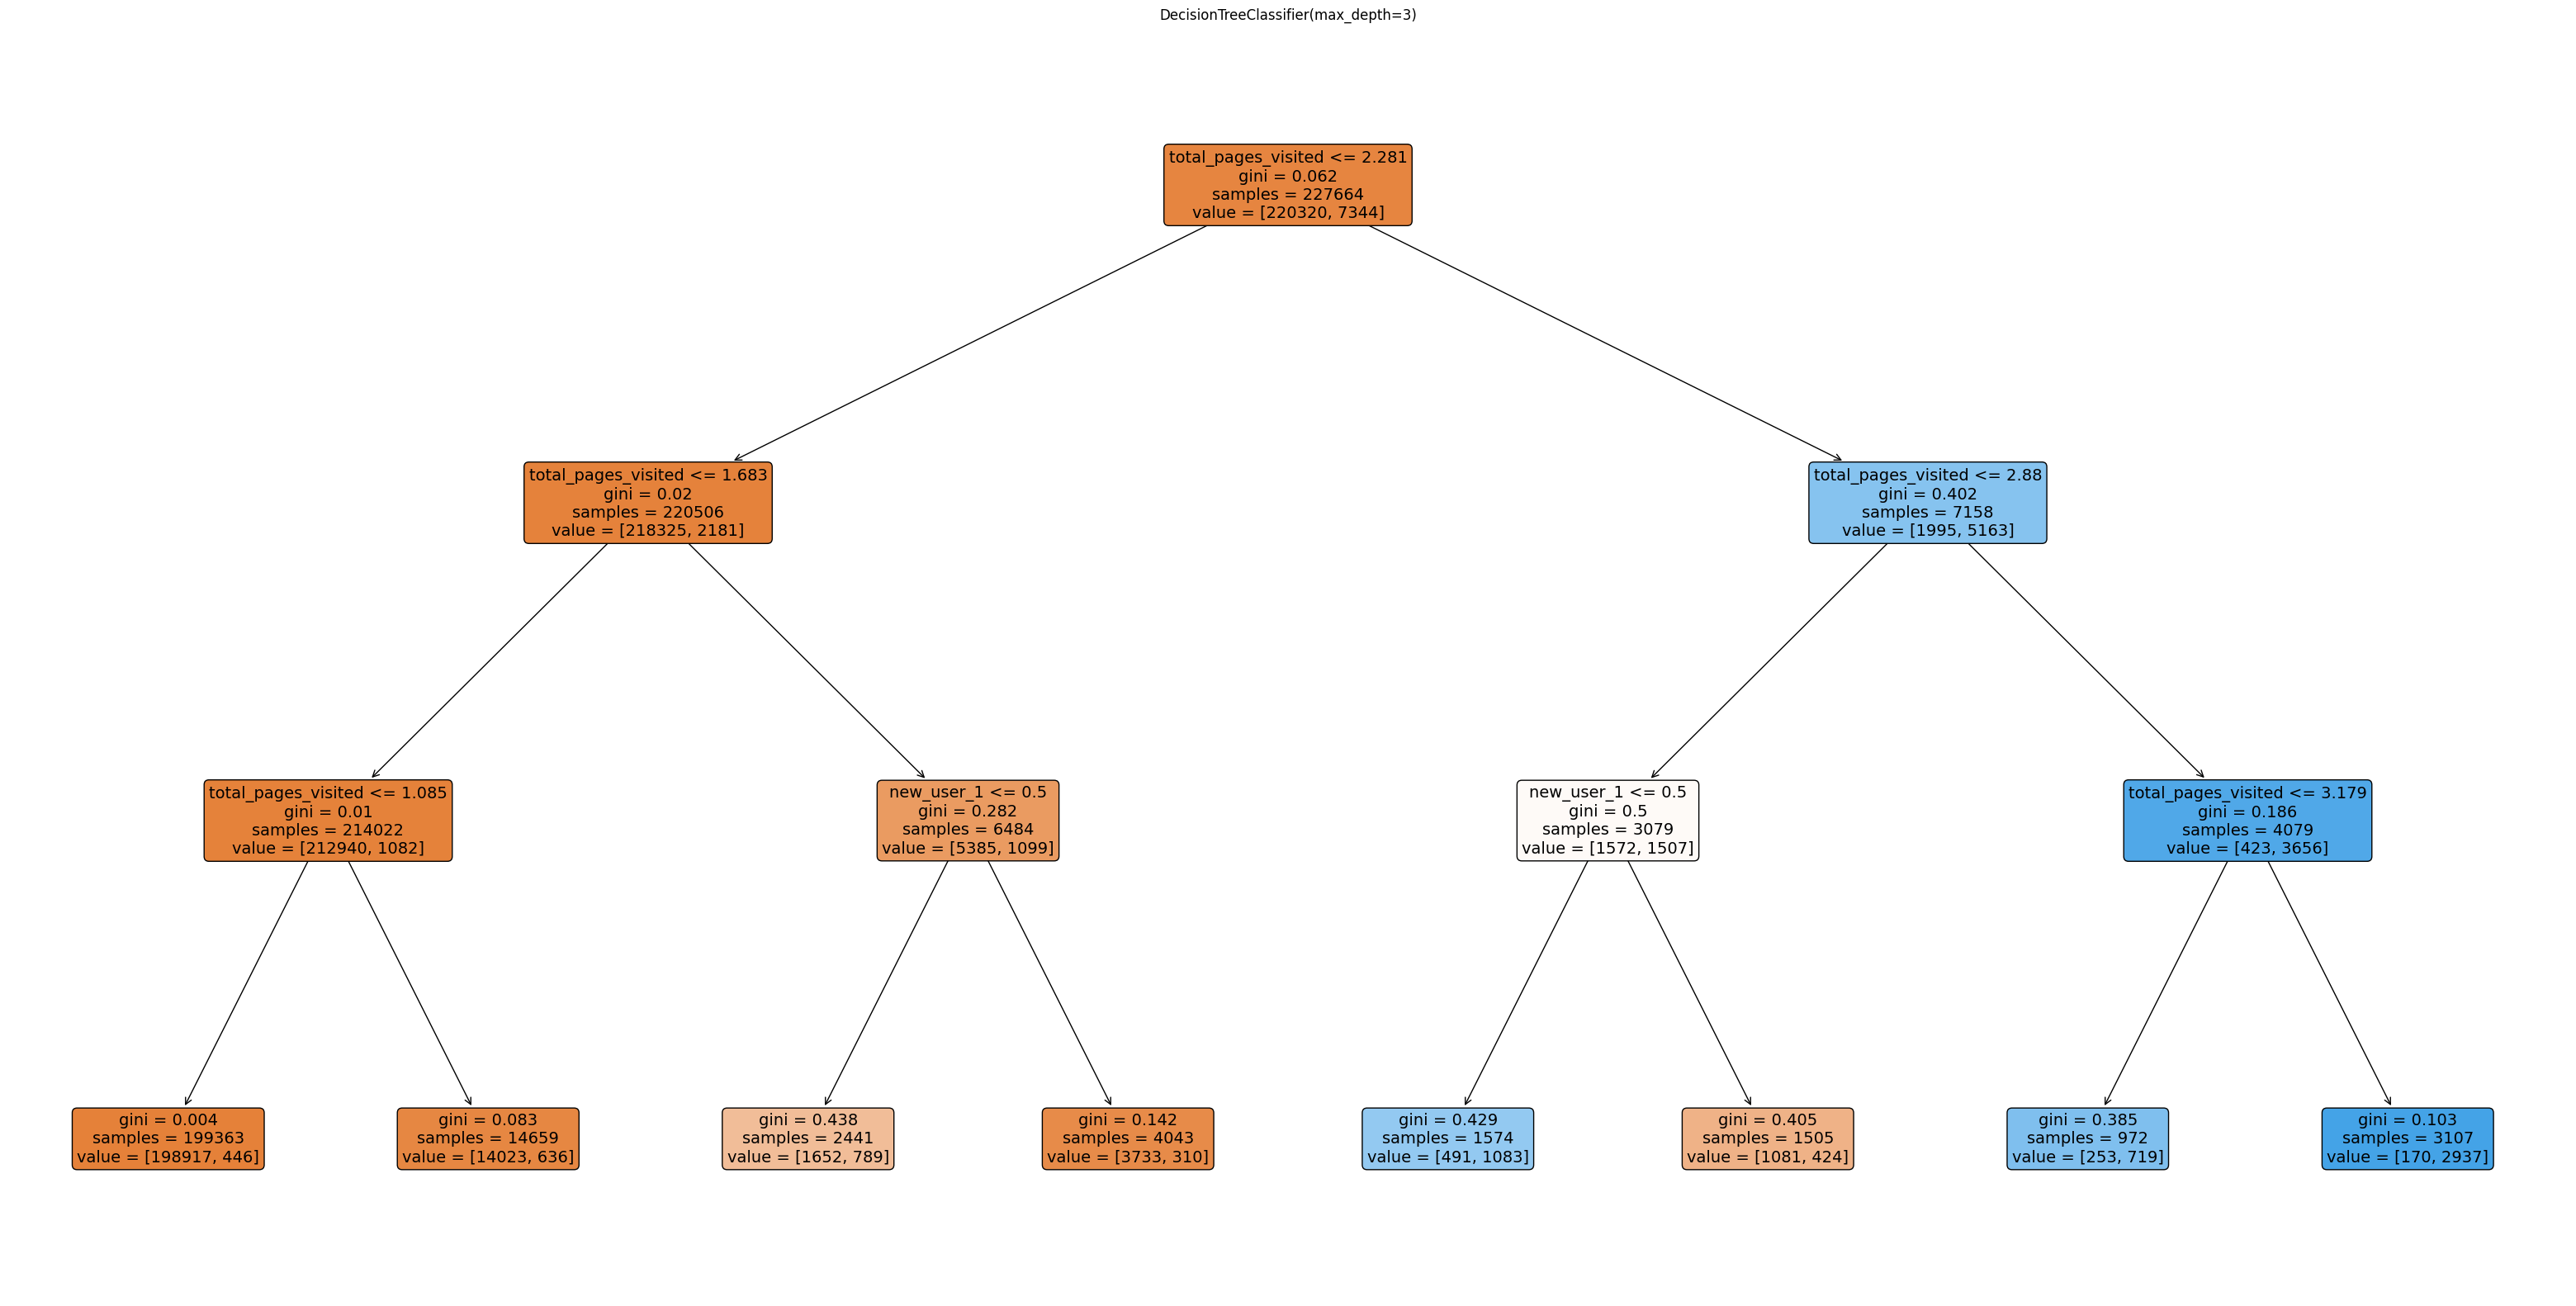

In [28]:
plt.figure(figsize=(40,20))
a = plot_tree(model, 
              feature_names=liste_features_name, 
              #class_names=class_names, 
              filled=True, 
              rounded=True, 
              fontsize=14)
plt.title(model)

### Apparemment, seules les variables total_pages_visited et new_user et age
### Comprendre la 1ère séparation, où tout une partie est compliquée à prédire...


In [83]:
### Comprendre la 1ère séparation, où tout une partie est compliquée à prédire...
### Apparemment, seules les cat total_pages_visited et new_user et age


# recupe donrmalisation pour faire le reverse encoding
X1 = data.loc[:,['age', 'total_pages_visited']]
Y2 = data.loc[:, 'converted']
X_train_bis,_ , _ , _ = train_test_split(X1, Y2, test_size=0.2, random_state=0, stratify = Y2)

norm = StandardScaler()
X_train_bis = norm.fit(X_train_bis)

#temp3['pages'] = temp3['tpv'].apply(lambda x: norm.inverse_transform(x))
#temp3
### je veux virer ce qui est > 2, 281

tpv = pd.DataFrame(temp.loc[:,['age', 'total_pages_visited']])
tpv.columns = ['age', 'tpv']

print(tpv[tpv['tpv']>2.281].count(), tpv[tpv['tpv']<=2.281].count(),) #7158, 220508

temp3 = tpv.loc[tpv['tpv']>2.281,:]
print(temp3.count())

temp3.reset_index(inplace = True) 
#temp3# index 0 and co ne fonctionne pas car mes indexe ne vont pas de 0 à x
temp3 = temp3.drop("index", axis = 1)
temp3

temp4 = pd.DataFrame(norm.inverse_transform(temp3), columns=['age', 'total_pages_visited'])
temp4.describe()
# pb avec les gens qui ont visité entre 11 et 14 pages...

#Entre 13 et 27 pages visitées:

age    7158
tpv    7158
dtype: int64 age    220506
tpv    220506
dtype: int64
age    7158
tpv    7158
dtype: int64


,age,total_pages_visited
count,7158.000000,7158.000000
mean,27.842693,15.758731
std,7.675267,2.720667
min,17.000000,13.000000
25%,22.000000,14.000000
50%,27.000000,15.000000
75%,33.000000,17.000000
max,123.000000,27.000000


# Models

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

## Regression Logistique

classification report train
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    192780
           1       0.86      0.66      0.75      6426

    accuracy                           0.99    199206
   macro avg       0.92      0.83      0.87    199206
weighted avg       0.98      0.99      0.98    199206

classification report val
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     82620
           1       0.85      0.66      0.74      2754

    accuracy                           0.99     85374
   macro avg       0.92      0.83      0.87     85374
weighted avg       0.98      0.99      0.98     85374

matrices de confusion


/tmp/ipykernel_6235/1729916919.py:134: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/tmp/ipykernel_6235/1729916919.py:139: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



,name_model,model,name_dataset,accuracy_train,accuracy_val,f1_train,f1_val
0,reglog_3fage,LogisticRegression(C=0.1),3fage,0.985628,0.98537,0.748396,0.74411


,name_model,model,name_dataset,tn_val,fp_val,fn_val,tp_val,tn_train,fp_train,fn_train,tp_train
0,reglog_3fage,LogisticRegression(C=0.1),3fage,82309,311,938,1816,192085,695,2168,4258


,name_model,model,name_dataset,parametres,coefficients
0,reglog_3fage,LogisticRegression(C=0.1),3fage,"{'C': 0.1, 'class_weight': None, 'dual': False...","[[2.4999748872116387, -1.641085069038355, 2.58..."


This function returns a Reporting DataFrame composed of:
   ['name_model', 'model', 'name_dataset', 'parametres', 'accuracy_train', 'accuracy_val', 'coefficients', 'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 'tn_val', 'fp_val', 'fn_val', 'tp_val', 'tn_train', 'fp_train', 'fn_train', 'tp_train', 'report_train', 'report_val', 'features_name']


,name_model,model,name_dataset,parametres,accuracy_train,accuracy_val,coefficients,y_train_pred,y_val_pred,f1_train,...,fp_val,fn_val,tp_val,tn_train,fp_train,fn_train,tp_train,report_train,report_val,features_name
0,reglog_full,LogisticRegression(),full,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.986331,0.985769,"[array([-0.59420066, 2.54863047, 3.57655197,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.765451,...,225,585,1251,219474,846,2266,5078,precision recall f1-score ...,precision recall f1-score ...,NaN
1,reglog_gs,LogisticRegression(C=0.1),full,"{'C': 0.1, 'class_weight': None, 'dual': False...",0.986318,0.985628,"[array([-0.5864657 , 2.51598049, 2.66063539,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.76439,...,225,593,1243,219496,824,2291,5053,precision recall f1-score ...,precision recall f1-score ...,NaN
2,reglog_ada_gs,AdaBoostClassifier(estimator=LogisticRegressio...,full,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.98511,0.98431,[],[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.735693,...,214,679,1157,219556,764,2626,4718,precision recall f1-score ...,precision recall f1-score ...,NaN
3,bag_tree_gs,BaggingClassifier(estimator=DecisionTreeClassi...,full,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.984543,0.984205,[],[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.729245,...,234,665,1171,219406,914,2605,4739,precision recall f1-score ...,precision recall f1-score ...,NaN
4,bag_tree_gs,BaggingClassifier(estimator=DecisionTreeClassi...,full,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.985373,0.984503,[],[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.750412,...,274,608,1228,219328,992,2338,5006,precision recall f1-score ...,precision recall f1-score ...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,reglog_new_user,LogisticRegression(C=1),1col,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.986376,0.985921,"[array([-0.5936974 , 2.53619193, 3.54553348,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.766115,...,338,864,1890,192047,733,1981,4445,precision recall f1-score ...,precision recall f1-score ...,NaN
63,reglog_source,LogisticRegression(C=1),1col,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.986376,0.985921,"[array([-0.5936974 , 2.53619193, 3.54553348,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.766115,...,338,864,1890,192047,733,1981,4445,precision recall f1-score ...,precision recall f1-score ...,NaN
64,reglog_total_pages_visited,LogisticRegression(C=1),1col,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.986376,0.985921,"[array([-0.5936974 , 2.53619193, 3.54553348,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.766115,...,338,864,1890,192047,733,1981,4445,precision recall f1-score ...,precision recall f1-score ...,NaN
65,reglog_converted,LogisticRegression(C=1),1col,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.986376,0.985921,"[array([-0.5936974 , 2.53619193, 3.54553348,...",[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0],0.766115,...,338,864,1890,192047,733,1981,4445,precision recall f1-score ...,precision recall f1-score ...,NaN


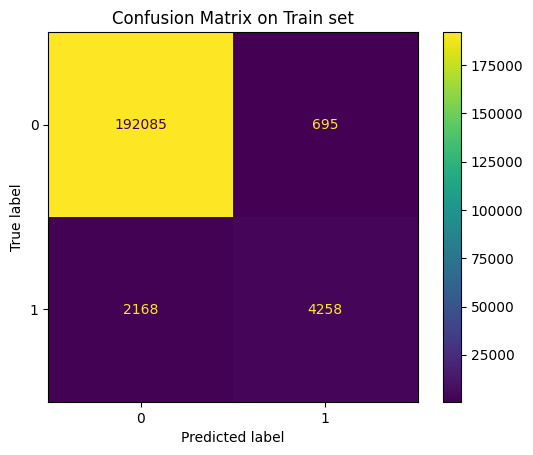

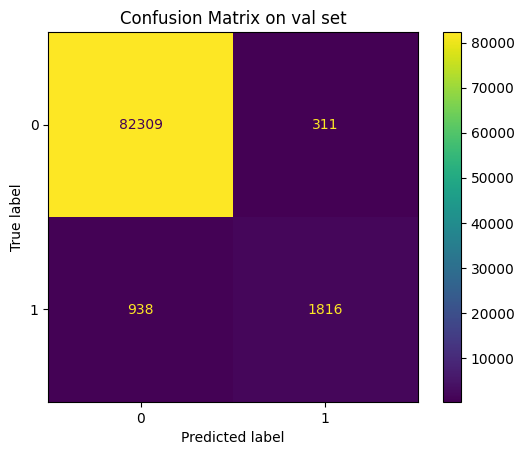

In [24]:
classifier = LogisticRegression(C=0.1, max_iter=100, penalty='l2') # 
classifier.fit(X_train, y_train)

#list_params = classifier.get_params()
#print(list_params)
'''
'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}
'''
reglog_3fage = model_scores(f'reglog_{name_dataset}', classifier, name_dataset, percent, liste_features_name)
final_scoring= pd.concat([final_scoring,reglog_3fage]) 
#0.764936	0.755274 4feat_eng2
#0.760645	0.748939 4feat_ eng1 -> moins bon.
#final_scoring = reglog_full
#0.764936	0.755274 feat4 = the best
# 4f_inf sur le test set complet...: 0.216237	0.752344 Trop chelou : Ca veut dire que mon train foire ?!?!?
# 4f_inf tv => horrible: 	0.192564	0.207906 avec les bons paramètres
# avec 40% en test : 0.72549	0.753488
# avec 30% en val : 0.729282	0.765432 _ le must
#4f_eng3 _ 0.763743	0.756637
#4f_eng4 _ 0.739302	0.732453 moins bon...
#4f_eng4_inf 0.371762	0.394161 _ pourri
#4f_eng4_sup 0.926013	0.929855 magnifique ! (on a beaucoup de 1...)
#3fage 0.748396	0.74411

final_scoring

In [20]:
liste_features_name

['total_pages_visited',
 'new_user_1',
 'country_Germany',
 'country_UK',
 'country_US']

<class 'pandas.core.frame.DataFrame'> (284580, 1) <class 'pandas.core.series.Series'> (284580,)
num_features are:[],
cat_features are:['country']
Dataset 1col is ready.


/home/melb/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/melb/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/melb/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/melb/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted sa

classification report train
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    192780
           1       0.00      0.00      0.00      6426

    accuracy                           0.97    199206
   macro avg       0.48      0.50      0.49    199206
weighted avg       0.94      0.97      0.95    199206

classification report val
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     82620
           1       0.00      0.00      0.00      2754

    accuracy                           0.97     85374
   macro avg       0.48      0.50      0.49     85374
weighted avg       0.94      0.97      0.95     85374

matrices de confusion


/tmp/ipykernel_24152/4239685746.py:132: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/tmp/ipykernel_24152/4239685746.py:137: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



,name_model,model,name_dataset,accuracy_train,accuracy_val,f1_train,f1_val
0,reglog_country,LogisticRegression(C=1),1col,0.967742,0.967742,0.0,0.0


,name_model,model,name_dataset,tn_val,fp_val,fn_val,tp_val,tn_train,fp_train,fn_train,tp_train
0,reglog_country,LogisticRegression(C=1),1col,82620,0,2754,0,192780,0,6426,0


,name_model,model,name_dataset,parametres,coefficients
0,reglog_country,LogisticRegression(C=1),1col,"{'C': 1, 'class_weight': None, 'dual': False, ...","[[3.7852952805735414, 3.603705391688258, 3.284..."


This function returns a Reporting DataFrame composed of:
   ['name_model', 'model', 'name_dataset', 'parametres', 'accuracy_train', 'accuracy_val', 'coefficients', 'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 'tn_val', 'fp_val', 'fn_val', 'tp_val', 'tn_train', 'fp_train', 'fn_train', 'tp_train', 'report_train', 'report_val']


KeyError: "['age'] not in index"

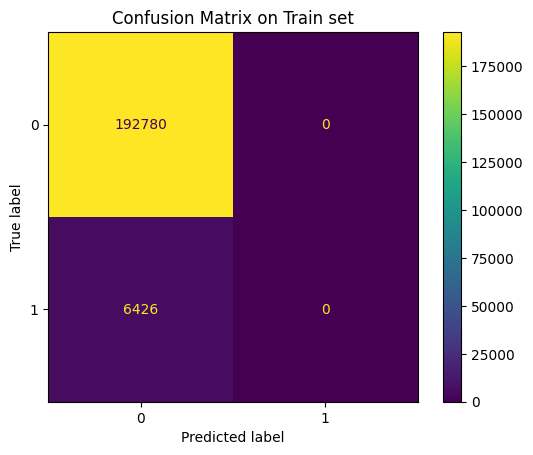

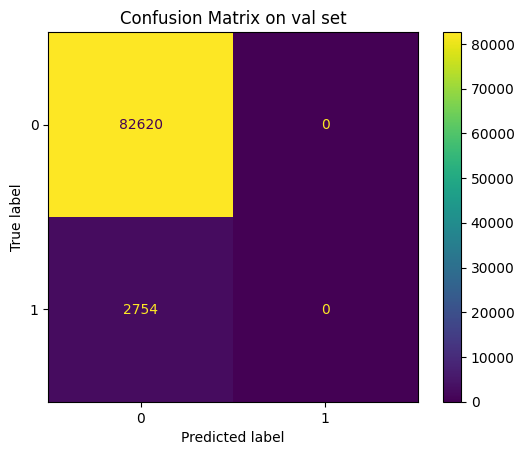

In [36]:
# pour faire PAR COLONNE

for col in data.columns:
    data = data.loc[:, [col,'converted']]
    X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset, percent = prepare_datasets(data, '1col', 0.3) 
    classifier = LogisticRegression(C=1) 
    classifier.fit(X_train, y_train)

    temp = model_scores(nom_variable('reglog_'+ col), classifier, name_dataset, percent)
    final_scoring= pd.concat([final_scoring,temp])
    



reglog - Gridsearch

In [ ]:
# Paramètres reglog - Gridsearch

logreg = LogisticRegression()

# Grid of values to be tested
params = {
    'C': [0.1, 1.0, 10.0],
    'penalty':['l1', 'l2']
}
reglog_opt = GridSearchCV(logreg, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
reglog_opt.fit(X_train, y_train)

 
reglog_gs_4f_eng4_inf = model_scores('reglog_gs_4f_eng4_inf', reglog_opt.best_estimator_, '4f_eng4_inf', percent)

final_scoring= pd.concat([final_scoring,reglog_gs_4f_eng4_inf])

reglog_gs_4f_eng4_inf.parametres[0]

#reglog_gs.parametres[0] 
''' 
{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

'''
# pasok avec 4f_eng4_inf  0.383951	0.399217

In [31]:
#reglog_gs.parametres # 'C': 0.1
reglog_gs.parametres[0]
#classification_report(y_train, y_train_pred)

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Boosting_reg_logistique
*AdaBoost (Boost s'entraine là où le modèle précédent s'est planté)


In [ ]:
### AdaBoost

logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
reglog_ada = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [0.01, 0.05, 0.1, 0.5], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [5, 10, 20, 30] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
reglog_ada_gs = GridSearchCV(reglog_ada, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
reglog_ada_gs.fit(X_train, y_train)

reglog_ada_gs = model_scores('reglog_ada_gs', reglog_ada_gs.best_estimator_, 'full')

final_scoring= pd.concat([final_scoring,reglog_ada_gs])
print(f'Adaboost_best_params = {reglog_ada_gs.parametres[0]}')

#Adaboost_best_params = {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator__C': 0.5, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 1000, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=0.5, max_iter=1000), 'learning_rate': 1.0, 'n_estimators': 30, 'random_state': None}

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')



### Decision Tree
* BaggingClassifier ou Randeom Forest v
* XGboost XGBoost (prédit l'ereur du précédent) - que decision treses v
* Adaboost

In [ ]:
decision_tree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 8, min_samples_leaf= 10, min_samples_split= 2)
#decision_tree = DecisionTreeClassifier(criterion= 'gini', max_depth= 5, min_samples_leaf= 1, min_samples_split= 2)
'''
'estimator__criterion': 'gini', '
estimator__max_depth': 8, 
'estimator__min_samples_leaf': 10, 
'estimator__min_samples_split': 2, 
 'n_estimators': 5,'''

decision_tree.fit(X_train, y_train)
tree_4f_eng4_sup = model_scores('tree_4f_eng4_sup', decision_tree, '4f_eng4_sup', percent)

final_scoring= pd.concat([final_scoring,tree_4f_eng4_sup])
# param classique : overfit à mort... Try avec gs...
#4feat_eng 1...0.781321	0.735632  overfitting
#4feat_eng 2...	0.781321 0.737001  overfitting _ idem
#4f - pas top, overfitting 0.781321	0.736619 
#4f_inf: 0.2852	0.500575
# tree_4f_full_30% val: 0.74934	0.704545 avec best_param
#tree_4f_full_30% val avec max_dept=5, min sample = 1 , 0.761644	0.715152 overfitting... pas cool...
#4f_eng3 # 0.76587	0.744195
#4f_eng4 #	0.76587	0.744195
#4f_eng4_inf #	0.421166	0.413836 pourri
#4f_eng4_sup #		0.929016	0.914555 super...

#4finf_tv, 0.275466	0.267568 mauvais

In [ ]:
# Perform grid search
decision_tree = DecisionTreeClassifier()
bag_tree = BaggingClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [4, 5, 8, 10],
    'base_estimator__min_samples_leaf': [1, 2, 5, 10],
    'base_estimator__min_samples_split': [2, 3, 4, 5],
    'n_estimators': [5, 10, 30, 50]
}
print(params)
bag_tree_gs3 = GridSearchCV(bag_tree, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
bag_tree_gs3.fit(X_train, y_train)

bag_tree_eng_10000_gs = model_scores('bag_tree_1000_feat_eng_gs', bag_tree_gs3.best_estimator_, '10000_feat_eng')

final_scoring= pd.concat([final_scoring,bag_tree_eng_10000_gs])
print(f'bagtree_best_params = {bag_tree_gs3.parametres[0]}')

#1. 'estimator__criterion': 'gini', estimator__max_depth': 3, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'n_estimators': 4
# 2estimator__criterion': 'gini', 'estimator__max_depth': 5,'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 3, 'n_estimators': 3
# les 2 sont identiques....

#avec le feat_eng total : tree = 0.790361	0.764706
# params gridsearch =  'estimator__criterion': 'gini', 'estimator__max_depth': 8, 'estimator__min_samples_leaf': 10, 'estimator__min_samples_split': 2,  'n_estimators': 5,

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')

Text(0.5, 1.0, 'DecisionTreeClassifier(max_depth=5)')

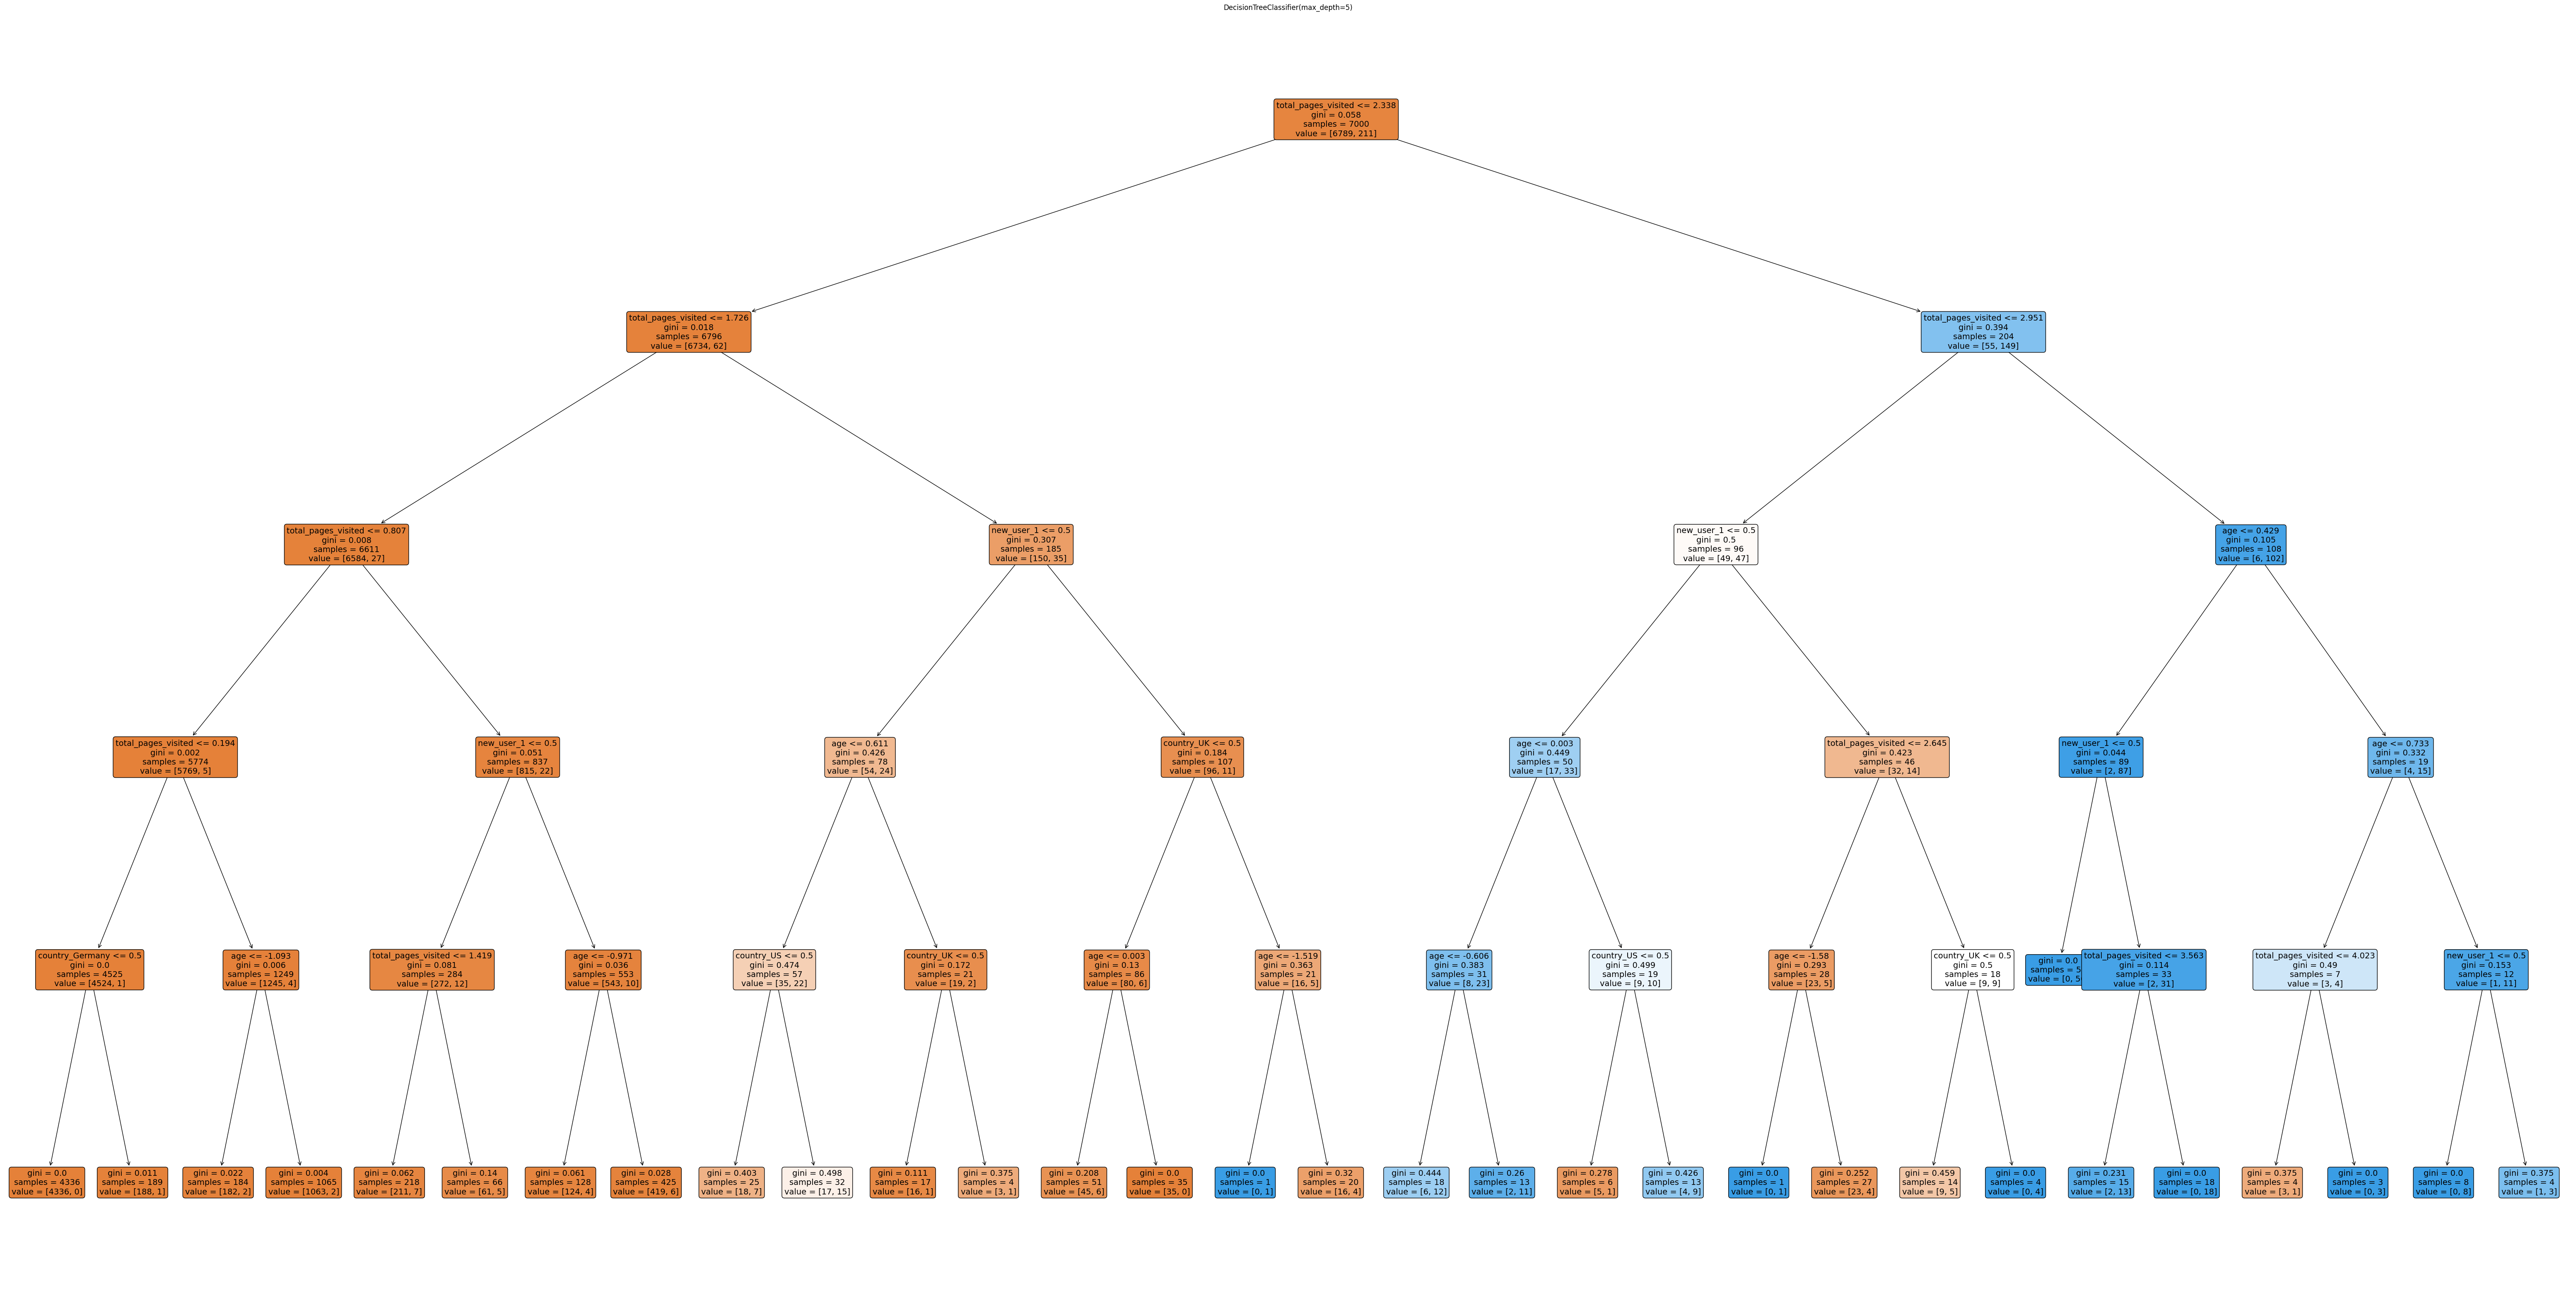

In [43]:
plt.figure(figsize=(80,40))
a = plot_tree(decision_tree, 
              feature_names=liste_features_name, 
              #class_names=class_names, 
              filled=True, 
              rounded=True, 
              fontsize=14)
plt.title(decision_tree)

In [ ]:
### A faire mais avec moins d'estimateurs peut être... pour trouver les bonnes valeurs au début... ou avec sample 1000_3f
decision_tree = DecisionTreeClassifier()
ada_tree = AdaBoostClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [2, 5, 8, 10],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'base_estimator__min_samples_split': [2, 3, 4],
    'n_estimators': [10, 30, 50, 100]
}
ada_gs = GridSearchCV(ada_tree, param_grid = params, cv = 3)
ada_gs.fit(X_train, y_train)

ada_gs_10000_3f = model_scores('ada_gs_10000_3f', ada_gs.best_estimator_, '10000_3f')

# sur 10000 = pas top: 0.705128	0.701754, 2' - 'estimator__criterion': 'gini', 'estimator__max_depth': 2, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2,'n_estimators': 10


final_scoring= pd.concat([final_scoring,ada_gs_10000_3f])

In [ ]:
### XGBoost: # que decision trees

### A refaire avec les nouveaux paramètres et full_3f

#reglog_xg = GradientBoostingClassifier(logistic_regression)

xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 5, 8], 
    'min_child_weight': [3, 10, 20], 
    'n_estimators': [30, 40, 50] 
}
print(params)
xg_gs2_4f_eng4_inf = GridSearchCV(xgboost, param_grid = params, cv = 3)
xg_gs2_4f_eng4_inf .fit(X_train, y_train)

xg_gs2_4f_eng4_inf = model_scores('xg_gs2_4f_eng4_inf', xg_gs2_4f_eng4_inf.best_estimator_, '4f_eng4_inf', percent)

final_scoring= pd.concat([final_scoring,xg_gs2_4f_eng4_inf])
# 0.74479	0.729927- # 'max_depth': 2, 'min_child_weight': 3,'n_estimators': 50 - 15 '
#0.711111	0.672566 'max_depth': 5, 'min_child_weight': 10,  'n_estimators': 40

# avec 4f_eng4_inf : 0.385198	0.395806 pourri... et pour les 0, comme d'hab'

,name_model,name_dataset,f1_train,f1_val,tn_train,fp_train,fn_train,tp_train,tn_val,fp_val,fn_val,tp_val
0,reglog_full,full,0.765451,0.755435,219474,846,2266,5078,54855,225,585,1251
1,reglog_country,country,0.765451,0.755435,219474,846,2266,5078,54855,225,585,1251
2,reglog_age,age,0.765451,0.755435,219474,846,2266,5078,54855,225,585,1251
3,reglog_new_user,new_user,0.765451,0.755435,219474,846,2266,5078,54855,225,585,1251
4,reglog_source,source,0.765451,0.755435,219474,846,2266,5078,54855,225,585,1251
...,...,...,...,...,...,...,...,...,...,...,...,...
61,voting_soft_2models_4f_full,4f_full,0.768372,0.752654,192033,747,1951,4475,82260,360,875,1879
62,stacking1_2models,4f_full,0.758125,0.755979,192118,662,2099,4327,82305,315,889,1865
63,bag_reglog1_full,full,0.766155,0.758828,192046,734,1980,4446,82281,339,863,1891
64,voting_soft_2models_full,full,0.768077,0.752010,192059,721,1970,4456,82269,351,883,1871


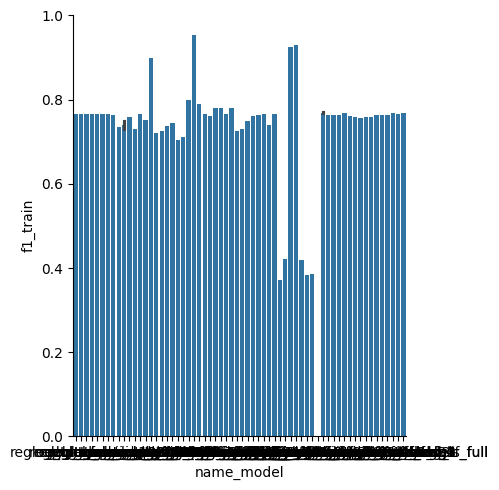

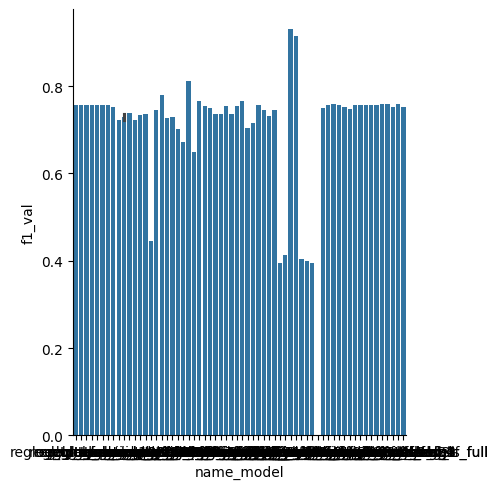

In [94]:
sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_train'], kind = 'bar')#, title='train')
sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')#, title='val')

# les derniers sortent bien, mais c'est parce que la somme des vrais neg et faux neg est bonnes... Faire les sommes et les stats en % pour voir... fn+tp et fp+tn
table_scoring = final_scoring.loc[:, ['name_model', 'name_dataset', 'f1_train', 'f1_val', 'tn_train', 'fp_train', 'fn_train', 'tp_train','tn_val', 'fp_val', 'fn_val', 'tp_val']]
table_scoring


In [ ]:
f1scoring = pd.DataFrame(data=[], columns = ['train_0_f1','train_0_#', 'train_0_f1', 'train_0_#', 'train_1_f1', 'train_1_#', 'val_0_f1', 'val_0_#', 'val_1_f1', 'val_1_#'])



for ligne in range(0, len(final_scoring), 1):
    train_0_f1 = int(final_scoring.loc[:, 'report_train'].values[ligne].split(' ')[34])
    f1scoring.loc[ligne, f1scoring['train_0_f1']] = final_scoring.loc[:, 'report_train'].values[ligne].split(' ')[53]
    f1scoring['train_0_#'][ligne] = final_scoring.loc[:, 'report_train'].values[ligne].split(' ')[57][:-1]

#float(final_scoring.loc[:, 'report_train'].values[item].split(' ')[34]) for item in final_scoring]
'''
,
float(final_scoring.loc[:, 'report_train'].values[18].split(' ')[53]),
float(final_scoring.loc[:, 'report_train'].values[18].split(' ')[57][:-1]),
float(final_scoring.loc[:, 'report_train'].values[18].split(' ')[68]),
float(final_scoring.loc[:, 'report_train'].values[18].split(' ')[87]),
float(final_scoring.loc[:, 'report_train'].values[18].split(' ')[93][:-2])


float(final_scoring.loc[:, 'report_val'].values[18].split(' ')[34]),
float(final_scoring.loc[:, 'report_val'].values[18].split(' ')[53]),
float(final_scoring.loc[:, 'report_val'].values[18].split(' ')[58][:-1]),
float(final_scoring.loc[:, 'report_val'].values[18].split(' ')[69]),
float(final_scoring.loc[:, 'report_val'].values[18].split(' ')[88]),
float(final_scoring.loc[:, 'report_val'].values[18].split(' ')[94][:-2])


'''

#[float(final_scoring.loc[:, 'report_train'].values[item].split(' ')[34]) for item in final_scoring]

In [13]:
f1scoring

,train_0_f1,train_0_#,train_0_f1,train_0_#,train_1_f1,train_1_#,val_0_f1,val_0_#,val_1_f1,val_1_#


In [9]:
#Sauvegarde final_scoring

final_scoring.to_csv('final_scoring.csv', index=False) 

In [8]:
final_scoring.loc[:, 'report_train'].values[ligne].split(' ')[53]

'0.99'

In [ ]:

classification_report

from sklearn.tree import plot_tree

class_names = encoder.inverse_transform([0, 1, 2])

plt.figure(figsize=(20,20))
a = plot_tree(classifier_gini, 
              feature_names=X.columns, 
              class_names=class_names, 
              filled=True, 
              rounded=True, 
              fontsize=14)

## SVC classifier - gridsearch
J'ai dû commencer par tester sur des plus petits dataset de 1000 (overfitting), puis 10000 observations car sinon, ça prenait trop de temps pour le gs sur le dataset full.

J'ai fait tourner en normal, pour m'assurer que tout était ok,  puis gs 1000, puis gs 10000 puis j'ai pris les best params pour les faire tourner en svc simple sur l'ensemble du dataset. Resultats ok, mais pas top non plus.

In [ ]:
svc = SVC(kernel = 'linear', gamma = 0.1, C = 0.1, probability = True) #


svc.fit(X_train, y_train)
 
svc_4f_eng4_inf = model_scores('svc_4f_eng4_inf ', svc, '4f_eng4_inf', percent)

final_scoring= pd.concat([final_scoring,svc_4f_eng4_inf])
#final_scoring.loc[final_scoring['name_model'] == '

#On 1000_3f = not enough 0. not ok. 0.89 on the train, only 0.44 on the val
#  10000_3f = 0.720879	0.745763
# full 13'  0.7384185613408862 0.7262604392205383]]
# avec sample et bonne % de 0 et 1_ 0.74023	0.72381
# svc-4f-4eng-inf 0.0	0.0

In [ ]:

# Perform grid search
svc = SVC(probability = True) # 'rbf'

# importer le final scoring
# Grid of values to be tested
params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1.0, 10.0],
    'gamma': [0.1, 1.0, 10.0]
}

svc_gs_m = GridSearchCV(svc, param_grid = params, cv = 3)
svc_gs_m .fit(X_train, y_train)

svc_3f_10000 = model_scores('svc_gs_3f_10000', svc_gs_m.best_estimator_, '10000_3f')

final_scoring= pd.concat([final_scoring,svc_3f_10000])
#final_scoring.loc[final_scoring['name_model'] == 'svc_gs', 'parametres'].values

# 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2,

sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')

# peut être fait avec DBScan, mais ce serait triché en ML Supervised
# moins bon en 3 feat
# sur 10000 _ 0.725738	0.780488_params : 
#{'C': 0.1, 'degree': 3, 'gamma': 0.1, 'kernel': 'linear'

## qu'est ce que ça veut dire : C 0.1 et gamma 0.1 sur ls données ? Car ce sont des valeurs faibles...

boosting svc, bagging svc


pis voting, stacking for all
puis sur dataset smaller... separer en 2...

Puis faire stacking arbre 2 leaves then le reste

voir avec DBScan su du feature engineering ? Garder le carré du total_pages _visited et le demi de age, new_user et country. 4f_eng. Retester sur le dataset complet.

[[0.7384185613408862 0.7262604392205383]]


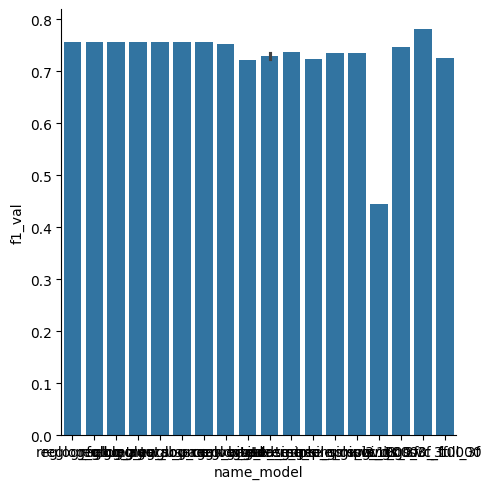

In [38]:
print(final_scoring.loc[final_scoring['name_model']=='svc_full_3f', ['f1_train', 'f1_val']].values)
sns.catplot(x = final_scoring['name_model'], y = final_scoring['f1_val'], kind = 'bar')



# Ensembl methods

In [48]:
liste_model = [ 'reglog_4f_eng3','tree_4f_eng3', 'reglog_4f_eng4_sup', 'bag_tree_1000_feat_eng_gs']
liste_index = [0, 35, 36, 41]
liste_col = ['coefficients', 'y_train_pred', 'y_val_pred','tn_val', 'fp_val', 'fn_val', 'tp_val', 'tn_train', 'fp_train', 'fn_train', 'tp_train', 'report_train', 'report_val']
    

best_models = final_scoring.drop(liste_col, axis = 1)
best_models = final_scoring.iloc[liste_index, :]
best_models

for item in best_models.index:
    print(best_models.loc[item, ['name_model']].values, best_models.loc[item, ['parametres']].values)

'''
'reglog_full', 'C': 1.0, 'max_iter': 100, 'penalty': 'l2',percent_val 0.2
'reglog_4f_eng3','C': 0.1, 'max_iter': 100,'penalty': 'l2',pecent_val 0.3
'tree_4f_eng3', 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 2, 'percent_val': 0.3
'reglog_4f_eng4_sup', 'C': 0.1, max_iter': 100, 'penalty': 'l2', 'percent_val': 0.3

'''

['reglog_full'] ["{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}"]
['reglog_4f_eng3'] ["{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False, 'percent_val': 0.3}"]
['tree_4f_eng3'] ["{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best', 'percent_val': 0.3}"]
['reglog_4f_eng4_sup'] ["{'C': 0.1, 'class_weight': None, 'dual':

## Bagging tree & reglog

In [ ]:
# Perform grid search
decision_tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 8, min_samples_leaf = 10, min_samples_split = 2)
bag_tree = BaggingClassifier(decision_tree)

# Grid of values to be tested
params = {
    'n_estimators': [50, 80, 100]
}
print(params)
bag_tree_gs5 = GridSearchCV(bag_tree, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
bag_tree_gs5.fit(X_train, y_train)

bag_tree_4f_eng3_gs = model_scores('bag_tree_4f_eng3_gs', bag_tree_gs5.best_estimator_, '4f_eng3', percent)

final_scoring= pd.concat([final_scoring,bag_tree_4f_eng3_gs])


# 0.769336	0.750399 _ # 'estimator': DecisionTreeClassifier(max_depth=8, min_samples_leaf=10), 'n_estimators': 50, 


In [ ]:
# Perform grid search
reglog1 = LogisticRegression(C =  1, penalty = 'l2')
bag_reglog1 = BaggingClassifier(reglog)

# Grid of values to be tested
params = {

    'n_estimators': [5, 10, 30, 50, 80, 100]
}
print(params)
bag_reglog_gs1 = GridSearchCV(bag_reglog1, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
bag_reglog_gs1.fit(X_train, y_train)

bag_reglog_4f_eng3_gs1 = model_scores('bag_reglog_4f_eng3_gs1', bag_reglog_gs1.best_estimator_, '4f_eng3', percent)

final_scoring= pd.concat([final_scoring,bag_reglog_4f_eng3_gs1])


# 0.763331	0.756887 - best so far wth 50 estmators C = 0.1
# 0.763526	0.755744 - best so far wth x estmators C = 1



In [ ]:
reglog1 = LogisticRegression(C =  1, penalty = 'l2')
bag_reglog1 = BaggingClassifier(reglog1, n_estimators = 50)

bag_reglog1.fit(X_train, y_train)
bag_reglog_4f_full_1 = model_scores('bag_reglog_4f_full_1', bag_reglog1, '4f_full', percent)
final_scoring= pd.concat([final_scoring,bag_reglog_4f_full_1])
# 4f_eng4 0.764645	0.758925
# 4f_full 0.764645	0.758925
# full 0.766155	0.758828



## Voting and Stacking

In [ ]:
# Voting
# voting avec various estimators:


decision_tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 8, min_samples_leaf = 10, min_samples_split = 2)
bag_tree = BaggingClassifier(decision_tree, n_estimators = 50)

decision_tree_log = DecisionTreeClassifier(criterion = 'log_loss', max_depth = 8, min_samples_leaf = 10, min_samples_split = 2)
bag_tree_log = BaggingClassifier(decision_tree_log, n_estimators = 50)


reglog = LogisticRegression(C = 0.1, penalty = 'l2')
bag_reglog = BaggingClassifier(reglog, n_estimators = 50)

reglog1 = LogisticRegression(C = 1, penalty = 'l2')
bag_reglog1 = BaggingClassifier(reglog, n_estimators = 50)

# reglog_4f_eng3, 
# tree_4f_eng3 - Random Forest
# reglog with  reglog_4f_eng4_sup
# bag_tree_1000_feat_eng_gs


voting_soft = VotingClassifier(estimators=[("bag_tree", bag_tree), ("bag_reglog", bag_reglog), ("bag_tree_log", bag_tree_log), ("bag_reglog1", bag_reglog1)], voting='soft') # soft: use probabilities for voting

voting_soft.fit(X_train, y_train)

#voting_soft_2models__4f_eng3 = model_scores('voting_soft_2models__4f_eng3', voting_soft, '4f_eng3', percent)
#final_scoring= pd.concat([final_scoring, voting_soft_2models__4f_eng3])

voting_soft_2models_full = model_scores('voting_soft_2models_full', voting_soft, 'full', percent)
final_scoring= pd.concat([final_scoring, voting_soft_2models_full])

print("Accuracy on training set : ", voting_soft.score(X_train, y_train))
print("Accuracy on val set", voting_soft.score(X_val, y_val))

# soft _ 4eng4f = 0.768861	0.752051
# soft _ 4f_full = 0.768372	0.752654
# soft _ full = 0.768077	0.75201


In [ ]:
voting_hard = VotingClassifier(estimators=[("bag_tree", bag_tree), ("bag_reglog", bag_reglog), ("bag_tree_log", bag_tree_log), ("bag_reglog1", bag_reglog1)], voting='hard') # hard: use probabilities for voting
voting_hard.fit(X_train, y_train)

voting_hard_2models_4f_eng3 = model_scores('voting_hard_2models_4f_eng3', voting_hard, '4f_eng3', percent)
final_scoring= pd.concat([final_scoring, voting_hard_2models_4f_eng3])

print("Accuracy on training set : ", voting_hard.score(X_train, y_train))
print("Accuracy on val set", voting_hard.score(X_val, y_val))

#hard _4eng4f 0.760986	0.748266

In [ ]:
#Stacking
#1, 2, 3, 4
# reglog_4f_eng3, 
# tree_4f_eng3 - Random Forest
# reglog with  reglog_4f_eng4_sup
# bag_tree_1000_feat_eng_gs


stacking1 = StackingClassifier(estimators = [("bag_tree", bag_tree), ("bag_reglog", bag_reglog), ("bag_tree_log", bag_tree_log), ("bag_reglog1", bag_reglog1)], cv = 3)
pred1 = stacking1.fit_transform(X_train, y_train)
#predictions = pd.DataFrame(preds, columns=stacking1.named_estimators_.keys())


print("Accuracy on training set : ", stacking1.score(X_train, y_train))
print("Accuracy on val set : ", stacking1.score(X_val, y_val))

stacking1_full = model_scores('stacking1_2models', stacking1, 'full', percent)
final_scoring= pd.concat([final_scoring, stacking1_full])

'''
#2,1,4,3

stacking2 = StackingClassifier(estimators = [ ("bag_reglog", bag_reglog), ("bag_tree", bag_tree),  ("bag_reglog1", bag_reglog1), ("bag_tree_log", bag_tree_log),], cv = 3)
pred1 = stacking2.fit_transform(X_train, y_train)
#predictions = pd.DataFrame(preds, columns=stacking2.named_estimators_.keys())


print("Accuracy on training set : ", stacking2.score(X_train, y_train))
print("Accuracy on val set : ", stacking2.score(X_val, y_val))

stacking2_4f_eng3 = model_scores('stacking2_2models', stacking2, '4f_eng3', percent)
final_scoring= pd.concat([final_scoring, stacking2_4f_eng3])



#1,3,2,4
stacking3 = StackingClassifier(estimators = [("bag_tree", bag_tree), ("bag_tree_log", bag_tree_log),("bag_reglog", bag_reglog),("bag_reglog1", bag_reglog1)], cv = 3)
pred1 = stacking3.fit_transform(X_train, y_train)
#predictions = pd.DataFrame(preds, columns=stacking3.named_estimators_.keys())


print("Accuracy on training set : ", stacking3.score(X_train, y_train))
print("Accuracy on val set : ", stacking3.score(X_val, y_val))

stacking3_4f_eng3 = model_scores('stacking3_2models', stacking3, '4f_eng3', percent)
final_scoring= pd.concat([final_scoring, stacking3_4f_eng3])

#2,4,1,3
stacking4 = StackingClassifier(estimators = [("bag_reglog", bag_reglog),("bag_reglog1", bag_reglog1), ("bag_tree", bag_tree), ("bag_tree_log", bag_tree_log)], cv = 3)
pred1 = stacking4.fit_transform(X_train, y_train)
#predictions = pd.DataFrame(preds, columns=stacking4.named_estimators_.keys())


print("Accuracy on training set : ", stacking4.score(X_train, y_train))
print("Accuracy on val set : ", stacking4.score(X_val, y_val))

stacking4_4f_eng3 = model_scores('stacking4_2models', stacking4, '4f_eng3', percent)
final_scoring= pd.concat([final_scoring, stacking4_4f_eng3])




'''

#stack1 _4eng4f 0.758416	0.756582
# stack2 _ 4enf_4f 0.757424	0.755979
# stack3 _ 4enf_4f 0.758138	0.755989
# stack4 _ 4enf_4f 0.758355	0.756285

#stack1 _ 4f_full 0.758125	0.755979
#stack1 _full 0.759385	0.75738

In [91]:
#Sauvegarde final_scoring

final_scoring.to_csv('final_scoring.csv', index=False)

In [ ]:
#Best_classifier
reglog1 = LogisticRegression(C =  1, penalty = 'l2')
bag_reglog1 = BaggingClassifier(reglog1, n_estimators = 50)

bag_reglog1.fit(X_train, y_train)
bag_reglog1_full = model_scores('bag_reglog1_full', bag_reglog1, 'full', percent)
final_scoring= pd.concat([final_scoring,bag_reglog1_full])
# 4f_4eng 0.764645	0.758925
# 4f_full 0.758925
# full 0.766155	0.758828

#bag_reglog_full_1 = model_scores('bag_reglog_full_1', bag_reglog1, 'full', percent)
#final_scoring= pd.concat([final_scoring,bag_reglog_full_1])

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

#X = np.append(X_train,X_val,axis=0)
#Y = np.append(y_train,y_val)

In [97]:
# Training Data
# no need to run for EDA
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)


# Preprocessng des new_user as category
data.new_user = data.new_user.astype('category')
data.info()


##4f_eng3
data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'country', 'converted']]
data['age_quart'], data['total_pages_visited_demi'] = data['age'].apply(lambda x: x/4), data['total_pages_visited'].apply(lambda x: x/2)
data = data.drop(['total_pages_visited', 'age'], axis = 1)

## X, Y sets:
X_train = data.drop('converted', axis = 1)
y_train = data.loc[:, 'converted']

print(type(X_train), X_train.shape, type(y_train), y_train.shape)


## Scaler, encoder:

# Recovery features category_name
num_features = []
cat_features = []

for col in X_train:
    if X_train[col].dtypes == 'int64' or X_train[col].dtypes == 'float64':
        num_features.append(col)
    else:
        cat_features.append(col)

num_features = num_features
print(f'num_features are:{num_features},\ncat_features are:{cat_features}')

# Preprocessings
norm = StandardScaler()
encod = OneHotEncoder(drop="first")

preprocesseur = ColumnTransformer(transformers=[
('num', norm, num_features),
('cat', encod, cat_features)])

X_train = preprocesseur.fit_transform(X_train)



Set with labels (our train+test) : (284580, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   country              284580 non-null  object  
 1   age                  284580 non-null  int64   
 2   new_user             284580 non-null  category
 3   source               284580 non-null  object  
 4   total_pages_visited  284580 non-null  int64   
 5   converted            284580 non-null  int64   
dtypes: category(1), int64(3), object(2)
memory usage: 11.1+ MB
<class 'pandas.core.frame.DataFrame'> (284580, 4) <class 'pandas.core.series.Series'> (284580,)
num_features are:['age_quart', 'total_pages_visited_demi'],
cat_features are:['new_user', 'country']


In [100]:

## Estimator_fitting & scoring
# Instanciation
reglog = LogisticRegression(C =  1, penalty = 'l2')
bag_reglog = BaggingClassifier(reglog, n_estimators = 50)

## Training
bag_reglog.fit(X_train, y_train)

## Prediction
y_train_pred = bag_reglog.predict(X_train)




matrices de confusion


/tmp/ipykernel_2714/731739634.py:12: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



f1_score_train: 0.7623756406391318, accuracy_train: 0.9861515215405159

{'base_estimator': 'deprecated', 'bootstrap': True, 'bootstrap_features': False, 'estimator__C': 1, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Classification report: 



'              precision    recall  f1-score   support\n\n           0       0.99      1.00      0.99    275400\n           1       0.85      0.69      0.76      9180\n\n    accuracy                           0.99    284580\n   macro avg       0.92      0.84      0.88    284580\nweighted avg       0.99      0.99      0.99    284580\n'

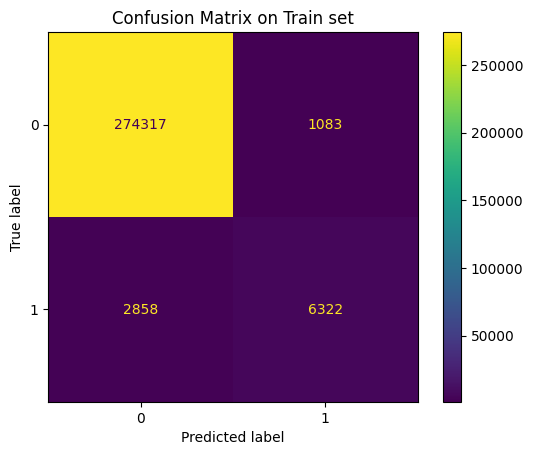

In [103]:
## Scorings

### Confusion matrix
tn_train, fp_train = confusion_matrix(y_train, y_train_pred)[0,0], confusion_matrix(y_train, y_train_pred)[0,1]
fn_train, tp_train = confusion_matrix(y_train, y_train_pred)[1,0], confusion_matrix(y_train, y_train_pred)[1,1]

    
print('matrices de confusion')
fig_train , ax1 = plt.subplots()
ax1.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(bag_reglog, X_train, y_train, ax=ax1) 
fig_train.show('notebook_connected')

'''
### Feature importance
try:
    coefficients = [coef for coef in bag_reglog.coef_]
except:
    coefficients =[]

 # recovery of columns names in X_train and X_val
liste_features_name = []    
for name in preprocesseur.get_feature_names_out():
    liste_features_name.append(name[5:])


print('Features_importance:')
feat_imp = pd.DataFrame([coef for coef in bag_reglog.coef_], columns=liste_features_name)

temp = feat_imp.transpose()
fig = px.bar(temp, x = abs(temp[0]), orientation='h', color=temp[0])
fig.update_layout(showlegend=False, title=f'Feature importance', font=dict(size=15), title_font_color="#8B1C62", margin=dict(l=150, r=20, t=50, b=40))
fig.update_yaxes(title = None)
fig.show()

'''
### Scorings
print(f'f1_score_train: {f1_score(y_train, y_train_pred)}, accuracy_train: {bag_reglog.score(X_train, y_train)}')
print()
print(bag_reglog.get_params())
print('\nClassification report: \n')
classification_report(y_train, y_train_pred)

#f1_score_train: 0.7623756406391318, accuracy_train: 0.9861515215405159
#{'base_estimator': 'deprecated', 'bootstrap': True, 'bootstrap_features': False, 'estimator__C': 1, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [111]:
data_without_labels = pd.read_csv('conversion_data_test.csv')
print(data_without_labels.shape)

data_without_labels.head()

(31620, 5)


,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


In [112]:
data_without_labels = data_without_labels.loc[:, ['age', 'total_pages_visited', 'new_user', 'country']]
data_without_labels['age_quart'], data_without_labels['total_pages_visited_demi'] = data_without_labels['age'].apply(lambda x: x/4), data_without_labels['total_pages_visited'].apply(lambda x: x/2)
X_test = data_without_labels.drop(['total_pages_visited', 'age'], axis = 1)

print(X_test.shape, X_test.columns)
X_test.head()

X_test = preprocesseur.transform(X_test)
X_test[0:5]

(31620, 4) Index(['new_user', 'country', 'age_quart', 'total_pages_visited_demi'], dtype='object')


,new_user,country,age_quart,total_pages_visited_demi
0,0,UK,7.00,8.0
1,1,UK,5.50,2.5
2,1,China,8.00,0.5
3,1,US,8.00,3.0
4,0,China,6.25,1.5


In [114]:

y_test_pred = bag_reglog.predict(X_test)

In [116]:
y_test_pred, len(y_test_pred)

(array([1, 0, 0, ..., 0, 1, 0]), 31620)

In [123]:
y_pred = pd.DataFrame(data = y_test_pred.tolist(), columns = ['pred'])
y_pred.shape, y_pred.head()

((31620, 1),
    pred
 0     1
 1     0
 2     0
 3     0
 4     0)

In [124]:
y_pred.to_csv('conversion_data_test_predictions_BERAUD_MELANIE_dfs27.csv', index=False)

# Test avec sup - trop d'erreur en %.... Il faudrait que je regarde mon tableau et que je fasses des %

In [4]:
##data_sup/data_inf ---------------------

# Training Data
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

# Preprocessng des new_user as category
data.new_user = data.new_user.astype('category')


### Keep the indexes to be able to sort afterwards and recover the data in the right order if required for evaluation or for prediction (needs to be well made)
#index_sup = [item for item in data.loc[data['total_pages_visited'] > 13, : ].index] # équivaut à > 13 pages visitées 
#index_inf = [item for item in data.loc[data['total_pages_visited'] <= 13, : ].index] 


### create 2 datasets according to the norm_total_pages_visited
data_sup = data.loc[data['total_pages_visited'] > 13, : ]
data_sup.reset_index(inplace=True)
data_sup = data_sup.drop('index', axis = 1)

print(data_sup.shape, data_sup.head())

# On garde data_sup pour faire le modèle sup
data = data_sup

data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'country', 'converted']]
data['age_quart'], data['total_pages_visited_demi'] = data['age'].apply(lambda x: x/4), data['total_pages_visited'].apply(lambda x: x/2)
data = data.drop(['total_pages_visited', 'age'], axis = 1)


Set with labels (our train+test) : (284580, 6)
(6728, 6)    country  age new_user source  total_pages_visited  converted
0  Germany   20        0    Seo                   14          1
1  Germany   27        1    Ads                   14          1
2       UK   27        0    Seo                   16          1
3       US   32        1    Seo                   19          1
4       US   41        0    Seo                   20          1


In [5]:
## X, Y sets:
X_train = data.drop('converted', axis = 1)
y_train = data.loc[:, 'converted']

print(type(X_train), X_train.shape, type(y_train), y_train.shape)


## Scaler, encoder:

# Recovery features category_name
num_features = []
cat_features = []

for col in X_train:
    if X_train[col].dtypes == 'int64' or X_train[col].dtypes == 'float64':
        num_features.append(col)
    else:
        cat_features.append(col)

num_features = num_features
print(f'num_features are:{num_features},\ncat_features are:{cat_features}')

# Preprocessings
norm = StandardScaler()
encod = OneHotEncoder(drop="first")

preprocesseur = ColumnTransformer(transformers=[
('num', norm, num_features),
('cat', encod, cat_features)])

X_train = preprocesseur.fit_transform(X_train)


<class 'pandas.core.frame.DataFrame'> (6728, 4) <class 'pandas.core.series.Series'> (6728,)
num_features are:['age_quart', 'total_pages_visited_demi'],
cat_features are:['new_user', 'country']


matrices de confusion


/tmp/ipykernel_4333/1786981829.py:19: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



f1_score_train: 0.9289521978502141, accuracy_train: 0.8791617122473246

{'base_estimator': 'deprecated', 'bootstrap': True, 'bootstrap_features': False, 'estimator__C': 1, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Classification report: 



'              precision    recall  f1-score   support\n\n           0       0.74      0.50      0.60      1199\n           1       0.90      0.96      0.93      5529\n\n    accuracy                           0.88      6728\n   macro avg       0.82      0.73      0.76      6728\nweighted avg       0.87      0.88      0.87      6728\n'

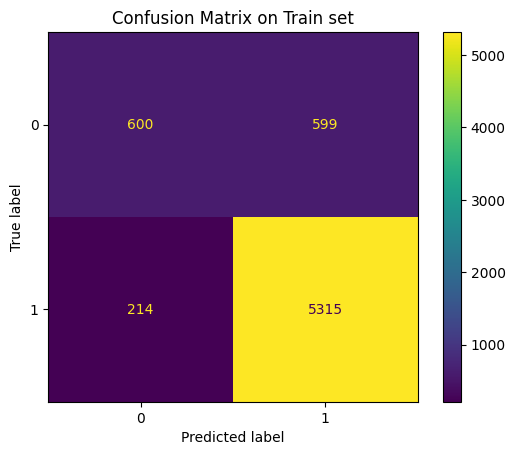

In [9]:
# Instanciation & fitting
reglog_sup = LogisticRegression(C=1, max_iter=100, penalty='l2') # 
bag_reglog_sup = BaggingClassifier(reglog_sup, n_estimators = 50)

bag_reglog_sup.fit(X_train, y_train)
## Prediction
y_train_pred_sup = bag_reglog_sup.predict(X_train)

## Scoring
### Confusion matrix
tn_train, fp_train = confusion_matrix(y_train, y_train_pred_sup)[0,0], confusion_matrix(y_train, y_train_pred_sup)[0,1]
fn_train, tp_train = confusion_matrix(y_train, y_train_pred_sup)[1,0], confusion_matrix(y_train, y_train_pred_sup)[1,1]

    
print('matrices de confusion')
fig_train , ax1 = plt.subplots()
ax1.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(bag_reglog_sup, X_train, y_train, ax=ax1) 
fig_train.show('notebook_connected')

'''
### Feature importance
try:
    coefficients = [coef for coef in bag_reglog.coef_]
except:
    coefficients =[]

 # recovery of columns names in X_train and X_val
liste_features_name = []    
for name in preprocesseur.get_feature_names_out():
    liste_features_name.append(name[5:])


print('Features_importance:')
feat_imp = pd.DataFrame([coef for coef in bag_reglog.coef_], columns=liste_features_name)

temp = feat_imp.transpose()
fig = px.bar(temp, x = abs(temp[0]), orientation='h', color=temp[0])
fig.update_layout(showlegend=False, title=f'Feature importance', font=dict(size=15), title_font_color="#8B1C62", margin=dict(l=150, r=20, t=50, b=40))
fig.update_yaxes(title = None)
fig.show()

'''
### Scorings
print(f'f1_score_train: {f1_score(y_train, y_train_pred_sup)}, accuracy_train: {bag_reglog_sup.score(X_train, y_train)}')
print()
print(bag_reglog_sup.get_params())
print('\nClassification report: \n')
classification_report(y_train, y_train_pred_sup)

#f1_score_train: 0.9289521978502141, accuracy_train: 0.8791617122473246, mais 50% d'erreur sur les 0, 20 %
#{'base_estimator': 'deprecated', 'bootstrap': True, 'bootstrap_features': False, 'estimator__C': 1, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 100, 'estimator__multi_class': 'auto', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(C=1), 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}



# Recovery of prediction to create a y_train et y_test

In [69]:
# shit ----
predictions = final_scoring.loc[:,['name_model','y_train_pred', 'y_val_pred']].values #gives arrays
predictions[0][1] # a refaire car les prédictions sont tronquées...

# shit, les ypred and co ont été renregistrées en texte et pas en liste :( donc irrécupérables...

#ype(predictions.y_train_pred[1]) # not ok... 17 str

'''Not used anymore - not ok, car take only a part...
liste_temp = ['bag_reglog1_full', 'reglog_4f_eng4_sup']

#predictions = final_scoring.loc[final_scoring['name_model'] == liste_temp, :]
predictions = final_scoring.loc[final_scoring['name_model']== 'bag_reglog1_full', :]
predictions2 = final_scoring.loc[final_scoring['name_model']== 'reglog_4f_eng4_sup', :] 
predictions = pd.concat([predictions, predictions2])
predictions = predictions.loc[:, ['name_model', 'f1_train', 'f1_val', 'y_train_pred', 'y_val_pred']]
predictions.reset_index(inplace = True)
predictions = predictions.drop('index', axis = 1)
predictions

predictions.to_csv('20231205_prediction.csv', index=False) 
'''

# Import table
predictions = pd.read_csv('20231205_prediction.csv')
predictions

#Problème de taille ! Au niveau de l'enregistrement...

def recup_pred(data):
    nom_set = data
    nom_set # c'est un str... difficile de mettre en liste normale...
    nom_set = nom_set.replace(']', '')
    nom_set = nom_set.replace('[', '')
                            
    liste_temp = nom_set.split(' ')
    nom_set = [0 if a == '0' else 1 for a in liste_temp]
    return nom_set


y_train_pred_full, y_train_pred_sup = recup_pred(predictions.y_train_pred[0]), recup_pred(predictions.y_train_pred[1])
y_val_pred_full, y_val_pred_sup = recup_pred(predictions.y_val_pred[0]), recup_pred(predictions.y_val_pred[1])

len(y_train_pred_full), y_train_pred_sup # Aïe....

,name_model,f1_train,f1_val,y_train_pred,y_val_pred
0,bag_reglog1_full,0.766155,0.758828,[0 0 0 ... 0 0 0],[0 0 0 ... 0 0 0]
1,reglog_4f_eng4_sup,0.926013,0.929855,[1 1 1 ... 1 1 1],[1 0 1 ... 1 1 1]


In [ ]:
# no need to run for EDA
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

# Preprocessng des new_user as category
data.new_user = data.new_user.astype('category')
data.info()

# all columns = 'full'
#data
#name_dataset = 'full'

##4f - not eng.
data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'country', 'converted']]
name_dataset = '4f'

X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset, percent = prepare_datasets(data, name_dataset, 0.3) 

#X_train[0:5], type(X_train), len(X_train), y_train[0:5], type(y_train), len(y_train), X_train [0], y_train[0] # attention aux index
len(X_train) + len(X_val)

classification report train
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    192780
           1       0.86      0.69      0.76      6426

    accuracy                           0.99    199206
   macro avg       0.92      0.84      0.88    199206
weighted avg       0.99      0.99      0.99    199206

classification report val
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     82620
           1       0.85      0.69      0.76      2754

    accuracy                           0.99     85374
   macro avg       0.92      0.84      0.88     85374
weighted avg       0.99      0.99      0.99     85374

matrices de confusion


/tmp/ipykernel_25984/35193501.py:134: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/tmp/ipykernel_25984/35193501.py:139: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



,name_model,model,name_dataset,accuracy_train,accuracy_val,f1_train,f1_val
0,reglog_bag_full,"(LogisticRegression(C=1, random_state=16900212...",4f_4ng,0.986286,0.985921,0.764645,0.758925


,name_model,model,name_dataset,tn_val,fp_val,fn_val,tp_val,tn_train,fp_train,fn_train,tp_train
0,reglog_bag_full,"(LogisticRegression(C=1, random_state=16900212...",4f_4ng,82280,340,862,1892,192036,744,1988,4438


,name_model,model,name_dataset,parametres,coefficients
0,reglog_bag_full,"(LogisticRegression(C=1, random_state=16900212...",4f_4ng,"{'base_estimator': 'deprecated', 'bootstrap': ...",[]


This function returns a Reporting DataFrame composed of:
   ['name_model', 'model', 'name_dataset', 'parametres', 'accuracy_train', 'accuracy_val', 'coefficients', 'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 'tn_val', 'fp_val', 'fn_val', 'tp_val', 'tn_train', 'fp_train', 'fn_train', 'tp_train', 'report_train', 'report_val', 'features_name']


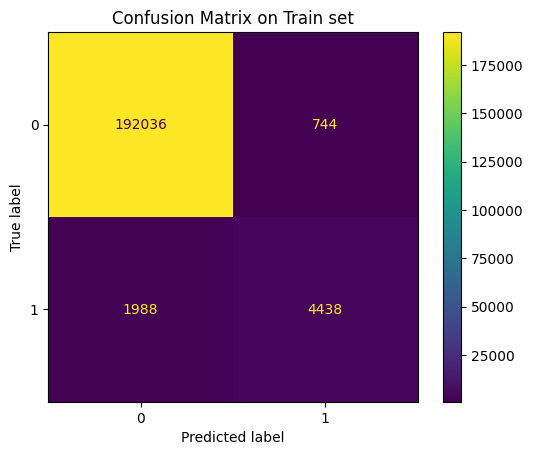

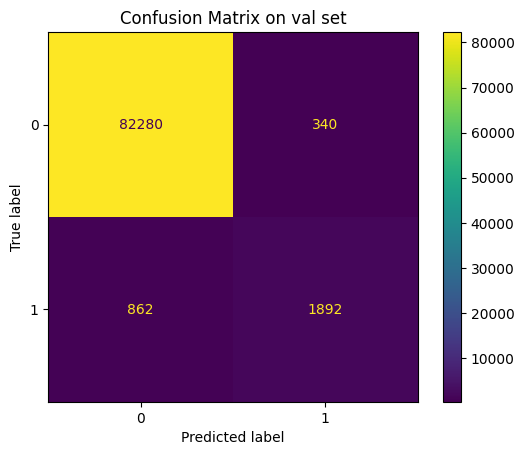

In [27]:
# 1 . model bagging sur dataset_4eng_4f - pour recovery yped

# model_pour full
## Estimator_fitting & scoring
# Instanciation
reglog = LogisticRegression(C =  1, penalty = 'l2')
bag_reglog = BaggingClassifier(reglog, n_estimators = 50)

## Training
bag_reglog.fit(X_train, y_train)

## Prediction

train_pred_full = model_scores('reglog_bag_full', bag_reglog, '4f_4ng', percent, features_full)
y_train_pred_full = bag_reglog.predict(X_train)
# 0.764645	0.758925 - pourri !
# 0.764645	0.758925 - ok. donc 4f


In [46]:
# 1 . model bagging sur dataset_4eng_4f - pour recovery yped

reglog = LogisticRegression(C =  1, penalty = 'l2')

## Training
reglog.fit(X_train, y_train)


reglog.coef_


array([[-0.59331658,  2.5360358 , -1.68992449,  3.54692572,  3.40021255,
         3.04868041]])

In [62]:
#train_pred_full.loc[:,['y_train_pred', 'y_test_pred'])

features_4f = liste_features_name
features_4f

y_train_pred_4f = [a for a in train_pred_full['y_train_pred'][0]]
y_val_pred_4f = [a for a in train_pred_full['y_val_pred'][0]]
y_coeff_4f = reglog.coef_

temp = [a for a in reglog.coef_]
y_coeff_4f = [a for a in temp[0]]
y_coeff_4f

[-0.5933165753721095,
 2.5360358035563006,
 -1.6899244859580296,
 3.546925722035128,
 3.400212550627519,
 3.048680411701816]

In [63]:
# no need to run for EDA
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

# Preprocessng des new_user as category
data.new_user = data.new_user.astype('category')
data.info()

# all columns = 'full'
#data
#name_dataset = 'full'

##4f - not eng.
data = data.loc[:, ['age', 'total_pages_visited', 'new_user', 'country', 'converted']]
#name_dataset = '4f'

### Keep the indexes to be able to sort afterwards and recover the data in the right order if required for evaluation or for prediction (needs to be well made)
index_sup = [item for item in data.loc[data['total_pages_visited'] > 13, : ].index] # équivaut à > 13 pages visitées 
index_inf = [item for item in data.loc[data['total_pages_visited'] <= 13, : ].index] 

print(len(index_sup), len(index_inf),  len(data), len(index_inf) + len(index_sup))
# to keep for later


### create 2 datasets according to the norm_total_pages_visited
data_sup = data.loc[data['total_pages_visited'] > 13, : ]
data_sup.reset_index(inplace=True)
data_sup = data_sup.drop('index', axis = 1)

data_sup.shape, data_sup.head()
name_dataset = '4f_sup'

# data_sup
data = data_sup
data.head()

X_train, X_val, y_train, y_val, num_features, cat_features, liste_features_name, name_dataset, percent = prepare_datasets(data, name_dataset, 0.3) 

#X_train[0:5], type(X_train), len(X_train), y_train[0:5], type(y_train), len(y_train), X_train [0], y_train[0] # attention aux index
len(X_train) + len(X_val)

Set with labels (our train+test) : (284580, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   country              284580 non-null  object  
 1   age                  284580 non-null  int64   
 2   new_user             284580 non-null  category
 3   source               284580 non-null  object  
 4   total_pages_visited  284580 non-null  int64   
 5   converted            284580 non-null  int64   
dtypes: category(1), int64(3), object(2)
memory usage: 11.1+ MB
6728 277852 284580 284580
<class 'pandas.core.frame.DataFrame'> (6728, 4) <class 'pandas.core.series.Series'> (6728,)
num_features are:['age', 'total_pages_visited'],
cat_features are:['new_user', 'country']
Dataset 4f_sup is ready.


6728

classification report train
              precision    recall  f1-score   support

           0       0.74      0.45      0.56       839
           1       0.89      0.97      0.93      3870

    accuracy                           0.87      4709
   macro avg       0.81      0.71      0.74      4709
weighted avg       0.86      0.87      0.86      4709

classification report val
              precision    recall  f1-score   support

           0       0.76      0.48      0.59       360
           1       0.90      0.97      0.93      1659

    accuracy                           0.88      2019
   macro avg       0.83      0.72      0.76      2019
weighted avg       0.87      0.88      0.87      2019

matrices de confusion


/tmp/ipykernel_25984/35193501.py:134: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/tmp/ipykernel_25984/35193501.py:139: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



,name_model,model,name_dataset,accuracy_train,accuracy_val,f1_train,f1_val
0,reglog_bag_sup,LogisticRegression(C=0.1),ef_sup,0.873221,0.880139,0.926013,0.929855


,name_model,model,name_dataset,tn_val,fp_val,fn_val,tp_val,tn_train,fp_train,fn_train,tp_train
0,reglog_bag_sup,LogisticRegression(C=0.1),ef_sup,173,187,55,1604,376,463,134,3736


,name_model,model,name_dataset,parametres,coefficients
0,reglog_bag_sup,LogisticRegression(C=0.1),ef_sup,"{'C': 0.1, 'class_weight': None, 'dual': False...","[[-0.5190205898228283, 1.7712958308829647, -1...."


This function returns a Reporting DataFrame composed of:
   ['name_model', 'model', 'name_dataset', 'parametres', 'accuracy_train', 'accuracy_val', 'coefficients', 'y_train_pred', 'y_val_pred', 'f1_train', 'f1_val', 'tn_val', 'fp_val', 'fn_val', 'tp_val', 'tn_train', 'fp_train', 'fn_train', 'tp_train', 'report_train', 'report_val', 'features_name']


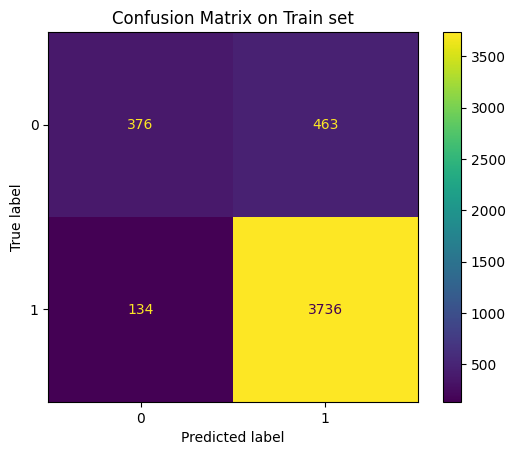

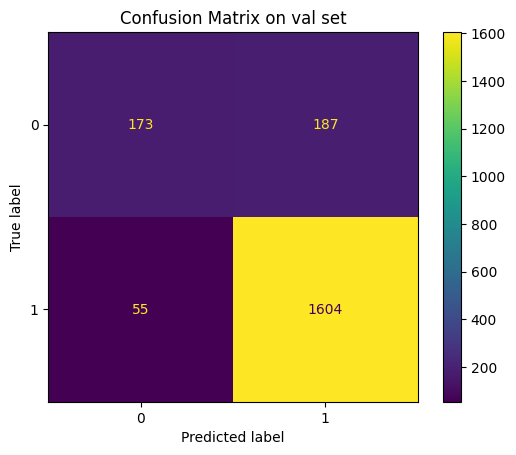

In [85]:
# 2. model non bagging for sup

features_sup = liste_features_name
features_sup

# model_pour full
## Estimator_fitting & scoring
# Instanciation
reglog = LogisticRegression(C =  0.1, penalty = 'l2')

## Training
reglog.fit(X_train, y_train)

## Prediction

train_pred_sup = model_scores('reglog_bag_sup', reglog, 'ef_sup', percent, features_sup)
y_train_pred_sup = reglog.predict(X_train)
# 	0.926013	0.929855 -ok


In [86]:
#train_pred_full.loc[:,['y_train_pred', 'y_test_pred'])

features_sup = liste_features_name
features_sup

y_train_pred_sup = [a for a in train_pred_sup['y_train_pred'][0]]
y_val_pred_sup = [a for a in train_pred_sup['y_val_pred'][0]]
y_coeff_sup = reglog.coef_

temp = [a for a in reglog.coef_]
y_coeff_sup = [a for a in temp[0]]
y_coeff_sup

[-0.5190205898228283,
 1.7712958308829647,
 -1.499264525665087,
 1.5579104448608394,
 1.7276232832749752,
 1.6022229338729095]

In [73]:

temp = final_scoring[35:37]

print(temp.loc[36,'parametres'])
#{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False, 'percent_val': 0.3}
#{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best', 'percent_val': 0.3}